<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Warehouse-Industry-Demographics" data-toc-modified-id="Warehouse-Industry-Demographics-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Warehouse Industry Demographics</a></span><ul class="toc-item"><li><span><a href="#And-where-to-find-employees-of-the-like" data-toc-modified-id="And-where-to-find-employees-of-the-like-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>And where to find employees of the like</a></span></li></ul></li><li><span><a href="#Import-Data" data-toc-modified-id="Import-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Import Data</a></span></li><li><span><a href="#Clean-Data" data-toc-modified-id="Clean-Data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Clean Data</a></span></li><li><span><a href="#Interpret-Results" data-toc-modified-id="Interpret-Results-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Interpret Results</a></span></li><li><span><a href="#Save-Results" data-toc-modified-id="Save-Results-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Save Results</a></span></li><li><span><a href="#Plot" data-toc-modified-id="Plot-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Plot</a></span></li><li><span><a href="#Ignore" data-toc-modified-id="Ignore-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Ignore</a></span></li></ul></div>

# Warehouse Industry Demographics
## And where to find employees of the like

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = '1' # need before importing kmeans bc kmeans has a memory leak

In [2]:
#import os
import json
import pandas as pd
from collections import defaultdict
from scipy.stats import wasserstein_distance
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
import ast
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import geopandas as gpd
import folium


In [3]:
from sklearn.metrics import silhouette_score
from sklearn.model_selection import GridSearchCV
from mpl_toolkits import mplot3d

In [4]:
%run Extract.ipynb 

'nbstripout' is not recognized as an internal or external command,
operable program or batch file.


In [5]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
#display(HTML("<style>.output_result { max-width:100% !important; }</style>"))

C:\Users\kzhang\AppData\Local\Temp\ipykernel_29156\323945219.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [6]:
# Global Variables
DATA_ROW_LIMIT = 10 # if a county has less than this amount of data points, the centroid county's data points will be combined with it 
focus_tracts_by_id = True # given numerically above? False if above list given my County names and not FIPS codes
using_geo_data = False

In [7]:
# Get Current Working Directory
cur_dir = os.getcwd()

# Directories
workers_dir = r"T:\Labor\Census QWI\JSON\QWI Labor Data"
geom_dir = r"T:\Geography\CensusTractJSON\2021"
tracts_dir = r"T:\Labor\Census QWI\JSON"
# Note: 4931 is for warehouse industry workers meanwhile 4921 is for deliveries

workers_filename = [filename for filename in os.listdir(workers_dir) if 'QWI_Labor_2021Q4_4931' in filename]
geom_filename = [filename for filename in os.listdir(geom_dir) if 'cb_2021_48_TX_tract_500k' in filename]
tracts_filename = [filename for filename in os.listdir(tracts_dir) if 'TX_CensusTract_QWI' in filename]

In [8]:
# For Mapping
# global variable
# cluster's color selections
colours = ['plum', 'lightblue', 'pink', 'cornflowerblue','khaki', 'salmon', 'violet', 'palegreen'] # match with clusters

In [9]:
'''
Maps census tracts
# has no color
'''
def map_tracts0(tracts):
    style1 = {'fillColor': '#E4E9FF', 'color': '#D4E0F9', 'weight': '2'}
    style1 = {'fillColor': 'oragne', 'color': '#D4E0F9', 'weight': '2'}
    lat_lon = [29.760427, -95.369803]
    m = folium.Map(location=[lat_lon[0], lat_lon[1]], zoom_start=9.9, tiles='OpenStreet Map')
    for _, r in tracts.iterrows():
        # Without simplifying the representation of each borough,
        # the map might not be displayed
        poly_type = r['type']
        polyr = r['coordinates']
        polys_to_map = []
        if poly_type == 'Polygon':
            for i in range(0, len(polyr)):
                polys_to_map.append(polyr[i])  
  
        if poly_type == 'MultiPolygon':
            for i in range(0, len(polyr)):
                polys_to_map.append(polyr[i][0])  
        for POLY in polys_to_map:      
            sim_geo = gpd.GeoSeries(Polygon(POLY)).simplify(tolerance=0.001)
            geo_j = sim_geo.to_json()
            geo_j = folium.GeoJson(data=geo_j,
                                   style_function=lambda x: style1)
            #folium.Popup(r['OBJECTID_x']).add_to(geo_j)
            geo_j.add_to(m)

    return m

In [10]:
'''
Maps census tracts
# works, has no labels though
'''
def map_tracts01(tracts):
    #style1 = {'fillColor': '#E4E9FF', 'color': '#D4E0F9', 'weight': '2'}
    
    lat_lon = [29.760427, -95.369803]
    m = folium.Map(location=[lat_lon[0], lat_lon[1]], zoom_start=9.9, tiles='OpenStreet Map')

    def polygon_style(row):
        cluster = row['cluster']
        return {'fillColor':colours[cluster], 'color':'#D4E0F9', 'weight': '2', 'fillOpacity' : 0.8}

    for _, r in tracts.iterrows():
        poly_type = r['type']
        polyr = r['coordinates']
        polys_to_map = []
        if poly_type == 'Polygon':
            for i in range(0, len(polyr)):
                polys_to_map.append(polyr[i])  
        if poly_type == 'MultiPolygon':
            for i in range(0, len(polyr)):
                polys_to_map.append(polyr[i][0])  
        for POLY in polys_to_map:      
            sim_geo = gpd.GeoSeries(Polygon(POLY)).simplify(tolerance=0.001)
            geo_j = sim_geo.to_json()
            geo_j = folium.GeoJson(data=geo_j,
                                   style_function=lambda feature, row=r: polygon_style(row))
            geo_j.add_to(m)

    return m

In [11]:
'''
Maps census tracts
Defines clusters and labels
'''
def map_tracts(tracts):
    #style1 = {'fillColor': '#E4E9FF', 'color': '#D4E0F9', 'weight': '2'}
    
    lat_lon = [33.7488, -84.3877]
    m = folium.Map(location=[lat_lon[0], lat_lon[1]], zoom_start=9.9, tiles='OpenStreet Map')

    def polygon_style(row):
        cluster = row['cluster']
        return {'fillColor':colours[cluster], 'color':'#D4E0F9', 'weight': '2', 'fillOpacity' : 0.8}

    for _, r in tracts.iterrows():
        poly_type = r['type']
        polyr = r['coordinates']
        polys_to_map = []
        if poly_type == 'Polygon':
            for i in range(0, len(polyr)):
                polys_to_map.append(polyr[i])  
        if poly_type == 'MultiPolygon':
            for i in range(0, len(polyr)):
                polys_to_map.append(polyr[i][0])  
        for POLY in polys_to_map:      
            sim_geo = gpd.GeoSeries(Polygon(POLY)).simplify(tolerance=0.00001)
            geo_j = sim_geo.to_json()
            geo_j = folium.GeoJson(data=geo_j,
                                   style_function=lambda feature, row=r: polygon_style(row), 
                                   tooltip=f"{county_dic[r['CountyFIPS']]}<br>{r['ID']}") # hover label 
            geo_j.add_to(m)

    return m

# Import Data

In [12]:
# County
# Ideal Worker Demographics
def import_workers_data(workers_dir, file_names):
    os.chdir(workers_dir)

    # go to this directory
    data_dir = workers_dir

    dfs = []  # List to store DataFrames from each file

    for file_name in file_names:
        # Import data from data file
        os.chdir(data_dir)
        with open(file_name, 'r') as myfile:
            data = myfile.read()

        # Parse file
        obj = json.loads(data)
        for dic in obj:
            dic['Male_Perc'] = dic['Gender']['Male']['Percent']
            dic['Female_Perc'] = dic['Gender']['Female']['Percent']
        df = pd.DataFrame(obj)

        exploded = df["AgeDistrib"].apply(pd.Series)
        exploded = exploded.rename({'Amount': 'Age_Amount', 'Bands': 'Age_Bands'}, axis=1)
        df = pd.concat([exploded, df], axis=1)

        exploded = df["Educ"].apply(pd.Series)
        exploded = exploded.rename({'Amount': 'Educ_Amount', 'Bands': 'Educ_Bands', 'NormalizedDistrb': 'Educ_NormalizedDistrb'}, axis=1)
        df = pd.concat([exploded, df], axis=1)

        exploded = df["RaceDistrib"].apply(pd.Series)
        exploded = exploded.rename({'Amount': 'Race_Amount', 'Bands': 'Race_Bands'}, axis=1)
        df = pd.concat([exploded, df], axis=1)

        df = df.drop(['Educ', 'AgeDistrib', 'Gender', 'RaceDistrib'], axis=1)
        dfs.append(df)

    # Concatenate all DataFrames in the list
    combined_df = pd.concat(dfs, ignore_index=True)

    return combined_df


workers = import_workers_data(workers_dir, workers_filename)

In [13]:
# census tracts
def import_tracts(tracts_dir, file_names):
    os.chdir(tracts_dir)
    
    dfs = []  # List to store DataFrames from each file

    for file_name in file_names:
        # Read JSON file into a DataFrame
        with open(file_name, 'r') as myfile:
            data = myfile.read()

        obj = json.loads(data)
        df = pd.DataFrame(obj)

        parsed_data = defaultdict(list)

        for entry in obj:
            recursive_parser(entry, parsed_data, "")

        d = dict(parsed_data)
        ddf = pd.DataFrame(d)
        exploded = ddf["Gender"].apply(pd.Series)
        exploded = exploded.rename({0: 'Male_Perc', 1: 'Female_Perc'}, axis=1)
        ddf = pd.concat([ddf, exploded], axis=1)
        ddf = ddf.drop(['Gender'], axis=1)
        dfs.append(ddf)

    # Concatenate all DataFrames in the list
    combined_df = pd.concat(dfs, ignore_index=True)

    return combined_df

tracts = import_tracts(tracts_dir, tracts_filename)

Note: 

for tracts, normalized vars include Distrb
AgeDistrib is the same as PopDistrb, with bands:
0 : "x14_18"
1 : "x19_21"
2 : "x22_24"
3 : "x25_34"
4 : "x35_44"
5 : "x45_54"
6 : "x55_64"
7 : "x65_99"

In [14]:
# import coordinate data
def import_geom(geom_dir, file_name):

    # import data from data file
    os.chdir(geom_dir)
    dir_files = os.listdir()

    # get geom data
    dir_files = [file_name] # so weird bc I used to concatenate (data input is given to me differently)

    # save all geometric ids here
    geom = pd.DataFrame()
    count = 0 # checker

    # loop starts here
    for file_name in dir_files:

        state_id = file_name.split('_tract')[0][8:] # ignore "cb_2018_" part
        print(state_id)

        os.chdir(geom_dir) # go back to data dir

        # read file
        with open(file_name, 'r') as myfile:
            data = myfile.read()

            # get IDs
            # parse file
            obj = json.loads(data)
            obj = obj['features']
            df = pd.DataFrame(obj)
            df1 = df['properties']
            json1 = df1.to_json(orient='records')
            obj1 = json.loads(json1)
            ddf = pd.DataFrame(obj1)

            # keep the following important variables
            features = ['STATEFP', 'COUNTYFP', 'TRACTCE', 'GEOID']
            tract_df = ddf[ddf.columns[ddf.columns.isin(features)]]

            # get Polygons
            # parse file
            obj = json.loads(data)
            obj = obj['features']
            df = pd.DataFrame(obj)
            df1 = df['geometry']
            json1 = df1.to_json(orient='records')
            obj1 = json.loads(json1)
            poly_df = pd.DataFrame(obj1)

            count += poly_df.shape[0]

            if tract_df.shape[0] != poly_df.shape[0]:
                print('uh-oh')
            new_df = pd.concat([tract_df, poly_df], axis = 1)

            geom = pd.concat([geom, new_df])
    return geom

In [15]:
if using_geo_data:
    geom = import_geom(geom_dir, geom_filename)

    to_drop = ['STATEFP', 'COUNTYFP', 'TRACTCE']
    geom.drop(to_drop, axis = 1, inplace = True)

    # Don't use geo data
    tracts = pd.merge(tracts, geom, left_on = "ID", right_on = "GEOID")


# Clean Data

In [16]:
#clean tracts
to_drop = ['Educ', 'Pop', 'Race']
tracts.drop(to_drop, axis=1, inplace=True)

In [17]:
tracts['Educ_Distrb'] = tracts['Educ_Distrb'].apply(lambda x: np.array(x))
tracts['PopDistrb'] = tracts['PopDistrb'].apply(lambda x: np.array(x))
tracts['CovarVector'] = tracts['CovarVector'].apply(lambda x: np.array(x))
tracts['Race_Distrib'] = tracts['Race_Distrib'].apply(lambda x: np.array(x))

In [18]:
tracts['ID'] = tracts.ID.astype('str')

In [19]:
# tracts county_FIPS code is the first 5 digits of the census tract ID
tracts['CountyFIPS'] = tracts['ID'].str.slice(stop=5).astype('float')

In [20]:
# decimal style 
'''
tracts['Educ_Distrb_10'] = tracts['Educ_Distrb'].apply(lambda x: [i*100 for i in x])
tracts['PopDistrb_10'] = tracts['PopDistrb'].apply(lambda x: [i*100 for i in x])
tracts['Male_Perc_10'] = tracts['Male_Perc'].apply(lambda x: x*100)
tracts['Female_Perc_10'] = tracts['Female_Perc'].apply(lambda x: x*100)
'''

"\ntracts['Educ_Distrb_10'] = tracts['Educ_Distrb'].apply(lambda x: [i*100 for i in x])\ntracts['PopDistrb_10'] = tracts['PopDistrb'].apply(lambda x: [i*100 for i in x])\ntracts['Male_Perc_10'] = tracts['Male_Perc'].apply(lambda x: x*100)\ntracts['Female_Perc_10'] = tracts['Female_Perc'].apply(lambda x: x*100)\n"

In [21]:
# percentage style
# file changed (some already in percentage mode)
workers['Educ_NormalizedDistrb_01'] = workers['Educ_NormalizedDistrb'].apply(lambda x: [i*.01 if i is not None else 0 for i in x ])

In [22]:
workers['Race_Amount'] = workers['Race_Amount'].apply(lambda x: [0 if i is None else i for i in x])

In [23]:
workers['Age_Amount'] = workers['Age_Amount'].apply(lambda x: [0 if i is None else i for i in x])

In [24]:
workers['Female_Perc'].fillna(0, inplace = True)
workers['Male_Perc'].fillna(0, inplace = True)

In [25]:
tracts['PopDistrb'] = tracts['PopDistrb'].apply(lambda x: [0 if i is None else i for i in x])
tracts['Educ_Distrb'] = tracts['Educ_Distrb'].apply(lambda x: [0 if i is None else i for i in x])
tracts['Race_Distrib'] = tracts['Race_Distrib'].apply(lambda x: [0 if i is None else i for i in x] if isinstance(x, list) else x)
tracts['Race_Distrib'] = tracts['Race_Distrib'].replace(np.nan, None)
# drop MeanCovar = Nan
tracts.dropna(subset=['MeanCovar'], inplace=True)


In [26]:
tracts['Female_Perc'].fillna(0, inplace = True)
tracts['Male_Perc'].fillna(0, inplace = True)

In [27]:
workers['Female_Perc'].fillna(0, inplace = True)
workers['Male_Perc'].fillna(0, inplace = True)

In [28]:
# bands

In [29]:
age_bands_dic = {0 : "x14_18", 1 : "x19_21", 2 : "x22_24", 3 : "x25_34", 4 : "x35_44", 5 : "x45_54", 6 : "x55_64", 7 : "x65_99"}
age_bands = list(age_bands_dic.values())

In [30]:
educ_bands_dic = {0 : "LessThanHighSchool", 1 : "HighSchoolOrEquivalent_NoCollege", 2 : "SomeCollegeOrAssociateDegree", 3 : "Bachelor_sDegreeOrAdvancedDegree", 4 : "EducationalAttainmentNotAvailable_workersAged24OrYounger_"}
educ_bands = list(educ_bands_dic.values())
educ_bands = educ_bands[:-1] # merge the first and last numbers together

In [31]:
gender_bands_dic = {0 : "Male", 1 : "Female"}
gender_bands = list(gender_bands_dic.values())

In [32]:
race_bands = ['WhiteAlone',
    'BlackOrAfricanAmericanAlone',
    'AmericanIndianOrAlaskaNativeAlone',
    'AsianAlone',
    'NativeHawaiianOrOtherPacificIslanderAlone',
    'TwoOrMoreRaceGroups']

In [33]:
def bhattacharyya_distance(p, q):
    """
    Computes the Bhattacharyya distance between two probability distributions.

    Parameters:
        p (ndarray): A probability distribution represented as an array of probabilities.
        q (ndarray): A probability distribution represented as an array of probabilities.

    Returns:
        float: The Bhattacharyya distance between the two probability distributions.
    """
    bc = np.sum(np.sqrt(np.multiply(p,q)))
    return -np.log(bc)


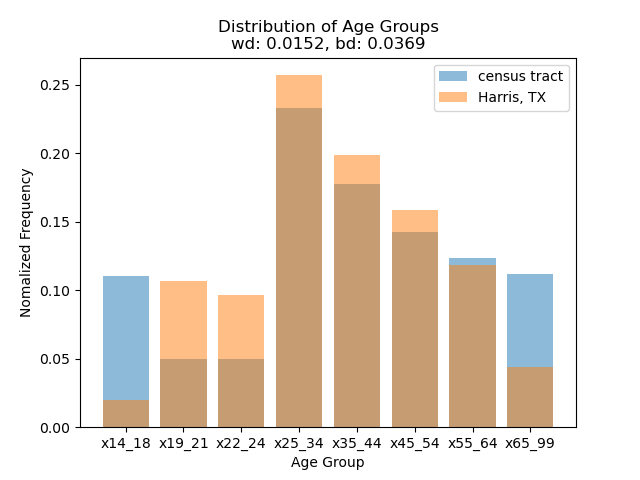

A good example of a possible age threshold (upper bound) for the bhattacharyya distance is .04 if clusters weren't chosen

In [34]:
def plot_distrb(wd, bd, bands, county_distrb, census_distrb, name): # name is just a string describing the plot
    #plot
    ID = tract_row['ID']
    # create a new figure
    fig = plt.figure()
    # create a histogram of the name = age/race/.. distribution
    plt.bar(bands, census_distrb, alpha=0.5, label = 'census tract')  #range(0, len(age_bands)))
    plt.bar(bands, county_distrb, alpha=0.5, label = county_name)
    # add labels and title

    plt.xlabel('Group')
    plt.ylabel('Nomalized Frequency')
    plt.title(f'Distribution of {name} Groups\nwd: {round(wd, 4)}, bd: {round(bd, 4)}')
    plt.legend()
    # save the figure to a file
    filename = f"{name}_{ID}.png"
    fig.savefig(f"histograms/{filename}")
    # display the figure
    plt.show()

In [35]:
def get_focus_tracts(focus_tracts_by_id, workers, list_of_tracts = []):
    # Atlanta, MSA
    # example output:
    # focus_tracts = [13013, 13015, 13035, 13045, 13057, 13063, 13067, 13077, 13085, 13089, 13097, 13113, 13117, 13121, 13135, 13143, 13149, 13151, 13159, 13171, 13199, 13211, 13217, 13223, 13227, 13231, 13247, 13255, 13297]
    # tracts are actually County FIPS codes
    if focus_tracts_by_id:
        if len(list_of_tracts) == 0:
            # get all tracts
            focus_tracts = workers['CountyFIPS'].unique() # make sure the first one in the centroid zipcode (representative) of Atlanta
        else:
            # counties of interest
            # by county FIPS codes
            focus_tracts = list_of_tracts
    else:
        # by name
        focus_tracts = [workers.loc[workers.County == list_of_tracts[i]]['CountyFIPS'].values[0] for i in range(len(list_of_tracts))] # if focus County FIPS codes aren't given -> get
    return focus_tracts
# focus_tracts = get_focus_tracts(focus_tracts_by_id, workers, list_of_tracts)

In [36]:
def county_xrf(focus_tracts):
    county_dic = dict()
    non_missing_tracts = []
    
    for num in focus_tracts:
        try:
            county_num = int(num)  # Convert the float key to an integer
            county_name = workers.loc[workers.CountyFIPS == num]['County'].values[0]
            county_dic.update({county_num: county_name})
            non_missing_tracts.append(county_num)
        except:
            print(num)
            
    focus_tracts = non_missing_tracts
    return county_dic

In [37]:
# Re-order the sequence in which the clusters will be made.
# Essentially, if there is not enough information to analyze and cluster set,
# this 'prioritized county' set will be pulled and included with the sparse one,
# everthing is also matched back to this county's initial groupings
# order_to_replace can be any ranking, without past argument, will default to order 0, first ranking
def prioritize_county(county_order, centroid_county_name, order_to_replace=0):
    # get number id from name
#     centroid_county_fips = workers.loc[workers.County == centroid_county_name]['CountyFIPS'].to_list()[0]
    
    # find the key that has 'order_to_replace' as value
    key_with_zero = [k for k, v in county_order.items() if v == order_to_replace][0]

    # save the value of key 'centroid_county_fips' in a temp variable
    temp = county_order[centroid_county_name]

    # switch the values
    county_order[centroid_county_name] = order_to_replace
    county_order[key_with_zero] = temp
    return county_order

In [38]:
def elbow_plot(X):
    # calculate the within-cluster sum of squares for different values of k
    wcss = []
    for k in range(1, 11):
        kmeans = KMeans(n_clusters=k, random_state=0)
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)

    # plot the within-cluster sum of squares against the number of clusters
    fig, ax = plt.subplots()
    ax.plot(range(1, 11), wcss)
    ax.set_xlabel('Number of clusters')
    ax.set_ylabel('Within-cluster sum of squares')
    ax.set_title('Elbow Method')

    plt.show()

In [39]:
# compute the mean of the variables for each cluster
# for renaming and mapping new county clusters back to the central one
all_clus_means = []

In [40]:
from collections import defaultdict

In [45]:
'''
Main Algorithm for Clustering (simple k-means)
'''
def model(area, county_dic,centroid_county_name):
    
    df_rows = area.shape[0]
    
    if df_rows < DATA_ROW_LIMIT:
        print('need more rows, merge with another county') # should have already done so in the prev function
        area['cluster'] = -1
        return area
    '''
    to_drop = ['Race_Distrib', 'Educ_Distrb', 'PopDistrb', 'Male_Perc', 'Female_Perc',
           'CovarVector', 'MeanCovar',
           'Educ_Distrb', 'PopDistrb', 'type', 'coordinates', 'GEOID', 'ID', 'CountyFIPS']
    '''
    # clean df
    if using_geo_data:
        to_drop = ['ID', 'CountyFIPS', 'GEOID', 'type', 'coordinates']

    else:
        to_drop = ['ID', 'CountyFIPS']
        
    # Q: Drop TransportWarehouseInd, Manufacturing? 
    X = area.drop(to_drop, axis = 1)
    print('X shape')
    print(X.shape)
    
    display(X)
    # Hyperparameter Tuning using Grid Search
    # Grid Search and CV for best parameters
    # uncomment to re-run analysis
    
    #kmeans = KMeans(n_init = 10, max_iter = 4, tol=1e-4, random_state = 0)
    kmeans = KMeans(random_state = 0)

    hyperparameter_tune = False
    print(f'hyperparameter tuning? {hyperparameter_tune}')
    if hyperparameter_tune:
        # define the hyperparameter grid
        MIN_CLUS = 2
        MAX_CLUS = 8 # maximum number of clusters
        max_n_clus = df_rows if df_rows < MAX_CLUS else MAX_CLUS
        n_clus_range = range(MIN_CLUS, max_n_clus, 2) 
        print('attempting cluster range: ')
        print(n_clus_range)
        param_grid = {
            'n_clusters': n_clus_range, # amount of clusters cannot exceed number of df rows. limits amount to less than 12
            'init': ['k-means++', 'random'],
            'algorithm': ['auto', 'full', 'elkan']
        }

        # note: cv breaks at 5
        grid_search = GridSearchCV(kmeans, param_grid=param_grid, cv=2) # can change scoring to silhouette score or Calinski-Harabasz (scoring = negative inertia is the default algo)
        grid_search.fit(X)

        # print the best parameters and score
        print('Best parameters:', grid_search.best_params_)
        print('Best score:', grid_search.best_score_) 

        grid_search.best_params_['algorithm']

        best_algo = grid_search.best_params_['algorithm']
        best_init = grid_search.best_params_['init']
        best_n_clus = grid_search.best_params_['n_clusters'] 
    
        # best parameters found for entire state of Georgia:
        # Best parameters: {'algorithm': 'auto', 'init': 'k-means++', 'n_clusters': 6}
    
    else:
        best_algo = 'auto'
        best_init = 'k-means++'
        best_n_clus = 6 # most said 6
    
    print('Parameters in use:')
    print(f'algorithm: {best_algo}')
    print(f'initializing with: {best_init}')
    print(f'clusters: {best_n_clus}')
    #kmeans = KMeans(n_init = 10, max_iter = 100, tol=1e-4, random_state = 0, algorithm = best_algo, init = best_init, n_clusters = best_n_clus) # removed max_iter and tol bc kernel dying
    kmeans = KMeans(random_state = 0, algorithm = best_algo, init = best_init, n_clusters = best_n_clus) 
    
    # Fit the model to the data
    kmeans.fit(X)
    
    # get centroids
    this_clus_means = kmeans.cluster_centers_    
    all_clus_means.append(this_clus_means)
    print(this_clus_means)
    #print(f'labels:\n{kmeans.labels_}')
    
    centroids = kmeans.cluster_centers_

    # Get the cluster labels for each centroid
    centroid_labels = kmeans.predict(centroids)

    # Print the centroid labels in order
    for i, label in enumerate(centroid_labels):
        print(f"Centroid {i}: label {label}")
    
    # Add the predicted cluster labels to the original data
    area['cluster'] = kmeans.predict(X) # may need to map og as well (is 0, 0 here?)
    
    plot_kmeans(area, county_dic) 
    
    print(f'NOT FINISHED.. Wait for re-grouping to original cluster {centroid_county_name}')
    # map to og clusters if not first cluster set
    mapping = {}
    replace_list = []
    if len(all_clus_means) > 1:
        # match the clusters based on the distance between the centers
        centers1 = all_clus_means[0]
        centers2 = this_clus_means
        print(f'how many clusters there should be: {len(centers2)}')
        for i in range(len(centers1)):
            distances = np.linalg.norm(centers1 - centers2[i], axis=1) # centers1 and centers2 should be on the same length => best_n_clus should remaint the same throughout the algorithm after 'general' hypertuning 
            j = np.argmin(distances)
            mapping[i] = j
            replace_list.append((i,j))

    area['cluster'] = area['cluster'].replace(mapping) # use mapping to point new clusters back to original X MSA's existing clusters
    
    # Print the counts of observations in each cluster
    print(area['cluster'].value_counts())
    plot_kmeans(area, county_dic)
    
    return area

In [42]:
# plot the data points with each cluster represented by a different color
def plot_kmeans(area, county_dic):
    
#     county_num = area['CountyFIPS'].tolist()[0]
#     county_name = county_dic[county_num]
    county_num = int(area['CountyFIPS'].tolist()[0])
    county_name = county_dic.get(county_num)

    fig, ax = plt.subplots()
    #colors = ['plum', 'lightblue', 'pink', 'cornflowerblue','khaki', 'salmon', 'violet', 'palegreen']
    markers = [ 'd','h', '+', 'x','*', '2', '3', '4']
    for i, cluster in area.groupby('cluster'):
        x = 'Educ_Bhat_Distance'
        y = 'AvgHHIncome'
        ax.scatter(cluster[x], cluster[y], c=colours[i], marker=markers[i], label=f'Cluster {i}')
    ax.legend()
    ax.set_xlabel(f'{x}')
    ax.set_ylabel(f'{y}')
    ax.set_title(f'Clusters for {county_name}')
    plt.savefig(f'{county_name}_income_educ_plot.png')
    plt.show()

    '''
    fig, ax = plt.subplots()
    for i, cluster in area.groupby('cluster'):
        x = 'Educ_Bhat_Distance'
        y = 'Age_Bhat_Distance'
        ax.scatter(cluster[x], cluster[y], c=colors[i], marker=markers[i], label=f'Cluster {i}')
    ax.legend()
    ax.set_xlabel(f'{x}')
    ax.set_ylabel(f'{y}')
    ax.set_title(f'Clusters for {county_name}')
    plt.savefig(f'{county_name}_age_educ_plot.png')
    plt.show()
    
    # 3d plot
    fig = plt.figure()
    ax = plt.axes(projection='3d')

    for i, cluster in area.groupby('cluster'):
        x = 'Educ_Bhat_Distance'
        y = 'Age_Bhat_Distance'
        z = 'AvgHHIncome'
        ax.scatter(cluster[x], cluster[y], cluster[z], c=colors[i], marker=markers[i], label=f'Cluster {i}')
    #ax.legend()
    ax.set_xlabel(f'{x}')
    ax.set_ylabel(f'{y}')
    ax.set_zlabel(f'{z}')
    ax.set_title(f'Clusters for {county_name}')
    plt.savefig(f'{county_name}_3D_plot.png')
    plt.show()
    '''
    
    

In [47]:
def main(centroid_county_name, DATA_ROW_LIMIT, project_place, focus_tracts, using_geo_data, order, county_dic):
    # os.chdir(cur_dir + '/model_output')
    os.chdir(r'C:\Projects\Constellation Warehouse Employee Demographic Clustering\model_output_test')
    # Note looking at histograms, a good threshold for overlapping distributions is 0.02 (for the wasserstein distance metric))
    all_area = pd.DataFrame()
    area = pd.DataFrame()

    workers_foc = workers.loc[workers['CountyFIPS'].isin(focus_tracts)] 
    workers_foc = workers_foc.reset_index(drop = True)
    metro_index = workers_foc.index[workers_foc.CountyFIPS == centroid_county_name][0] # replace with central county if missing data
    workers_foc = workers_foc.sort_values(by='CountyFIPS', key=lambda x: pd.Categorical(x, categories=order))
    
    tracts['Age_Bhat_Distance'] = np.nan
    tracts['Gender_Bhat_Distance'] = np.nan
    tracts['Educ_Bhat_Distance'] = np.nan
    tracts['Race_Bhat_Distance'] = np.nan

    # all other counties are empty (have no tracts)
    for index, row in workers_foc.iterrows():
        county_FIPS = row['CountyFIPS']
        county_name = row['County']
        county_age = row['Age_Amount'] # removed _01
        county_educ = row['Educ_NormalizedDistrb_01'] 
        county_gender = [row['Male_Perc'], row['Female_Perc']] # removed _01
        county_race = row['Race_Amount']
        print('--')
        print(county_name)

        # if don't know county code, can't get tracts that belong to it
        if county_FIPS is None: 
            continue

        # get census tracts that belong to this county
        area = tracts.loc[tracts['CountyFIPS'] == float(county_FIPS)]
        print(area.shape)
        
        this_row_shape = area.shape[0]
        print(f'Amount of available data points for {county_name}: {this_row_shape}')
        # Liberty, TX and Waller, TX have no records (not even age info)
        # or if a county doesnt have enough tract data to cluster
        # incorporate Harris county data
#         if (all(a == 0 for a in county_age) | (this_row_shape < DATA_ROW_LIMIT)):
        if (this_row_shape < DATA_ROW_LIMIT):
            print(f'Using {centroid_county_name} County warehouse demo data')
            old_county_FIPS = county_FIPS
            index = metro_index
            row = workers_foc.iloc[[metro_index]]
            county_FIPS = row['CountyFIPS'].values[0]
            county_name = row['County'].values[0]
            county_age = row['Age_Amount'].values[0] # removed _01
            county_educ = row['Educ_NormalizedDistrb_01'].values[0] 
            county_gender = [row['Male_Perc'].values[0], row['Female_Perc'].values[0]] # removed _01
            county_race = row['Race_Amount'].values[0]
            area = tracts.loc[tracts['CountyFIPS'].isin([float(county_FIPS), float(old_county_FIPS)])] # Harris county tracts will be duplicated -> clean later (drop duplicates if same color is established)

        new_row_shape = area.shape[0]
        print(f'Amount of available data points after merging with {centroid_county_name}: {new_row_shape}')
        if new_row_shape > 0:
            for index1, tract_row in area.iterrows():
                # Calculate the distance between the two age distributions
                this_age = tract_row['PopDistrb']
                wd = wasserstein_distance(county_age, this_age)
                bd = bhattacharyya_distance(county_age, this_age)
                area.at[index1, 'Age_Bhat_Distance'] = bd
                #plot_distrb(wd, bd, age_bands, county_age, this_age,'age')
                '''
                print('age')
                print(this_age)
                print(county_age)
                print(bd)
                print('--')
                '''
                # ---

                this_educ = tract_row['Educ_Distrb']
                wd = wasserstein_distance(county_educ, this_educ)
                bd = bhattacharyya_distance(county_educ, this_educ)
                area.at[index1, 'Educ_Bhat_Distance'] = bd
                #plot_distrb(wd, bd, educ_bands, county_educ, this_educ,'educ') # comment me out later
                '''
                print('educ')
                print(this_educ)
                print(county_educ)
                print(bd)
                print('--')
                '''
                # ---

                this_gender = [tract_row['Male_Perc'], tract_row['Female_Perc']]
                wd = wasserstein_distance(county_gender, this_gender)
                bd = bhattacharyya_distance(county_gender, this_gender)
                area.at[index1, 'Gender_Bhat_Distance'] = bd
                #plot_distrb(wd, bd, gender_bands, county_gender, this_gender,'gender')
                '''
                print('gender')
                print(this_gender)
                print(county_gender)
                print(bd)
                print('--')
                '''
                # ---

                this_race = tract_row['Race_Distrib']
#                 wd = wasserstein_distance(county_race, this_race)
                if this_race is not None:
                    bd = bhattacharyya_distance(county_race, this_race)
                    area.at[index1, 'Race_Bhat_Distance'] = bd 

#                 bd = bhattacharyya_distance(county_race, this_race)
#                 area.at[index1, 'Race_Bhat_Distance'] = bd 
                #plot_distrb(wd, bd, race_bands, county_race, this_race,'race')
                '''
                print(this_race)
                print(county_race)
                print(bd)
                print('--')
                '''

            # drop rows with infinite values -> breaks kmeans        
            to_drop = ['Race_Distrib', 'Educ_Distrb', 'PopDistrb', 'Male_Perc', 'Female_Perc',
               'CovarVector', 'MeanCovar',
               'Educ_Distrb', 'PopDistrb'] 

            area = area.drop(to_drop, axis = 1)
            area = area.replace([np.inf, -np.inf], np.nan)
            # replace inf values with nan (only in bhat distances columns)
            '''
            for col in area.columns:
                if 'bhat' in col:
                    area[col] = area[col].replace([np.inf, -np.inf], np.nan)
            '''
            print('\n\narea.shape')
            print(area.shape)
            area.dropna(inplace=True)
            print(area.shape)

            # -----
            # plug all into k-means
            area = model(area, county_dic, centroid_county_name)
            all_area = pd.concat([all_area, area]) # save results
           
            
            
            # renaming cluster numbers
            mode = all_area.groupby('ID')['cluster'].transform(lambda x: x.mode()[0])
            all_area['cluster'] = mode
            mean_clus_incomes = all_area.groupby(['cluster'], as_index = False).agg({'AvgHHIncome': 'mean'})
            tiers_df = mean_clus_incomes.sort_values(by='AvgHHIncome')
            cluster_to_tier = {cluster: tier + 1 for tier, cluster in enumerate(tiers_df['cluster'])}

            all_area['tier'] = all_area['cluster'].map(cluster_to_tier)
            
    return all_area 

{48201: 'Harris, TX', 48039: 'Brazoria, TX', 48071: 'Chambers, TX', 48157: 'Fort Bend, TX', 48167: 'Galveston, TX', 48015: 'Austin, TX', 48291: 'Liberty, TX', 48339: 'Montgomery, TX', 48473: 'Waller, TX'}
--
Harris, TX
(1572, 17)
Amount of available data points for Harris, TX: 1572
Amount of available data points after merging with 48201: 1572


area.shape
(1572, 10)
(786, 10)
X shape
(786, 8)


,TransportWarehouseInd,Manufacturing,AvgHHIncome,AvgDIncome,Age_Bhat_Distance,Gender_Bhat_Distance,Educ_Bhat_Distance,Race_Bhat_Distance
1677,251.0,441.0,137949,97553,0.023382,0.002428,0.124685,0.040191
1678,2.0,4.0,152334,110150,0.038610,0.068161,0.042980,0.050605
1679,94.0,191.0,41961,35619,0.049634,0.001146,0.021169,0.133505
1680,128.0,233.0,47845,39809,0.051108,0.001588,0.014368,0.170294
1681,302.0,219.0,73778,60652,0.068143,0.001411,0.020895,0.179721
...,...,...,...,...,...,...,...,...
2458,373.0,649.0,136310,103703,0.040432,0.002413,0.077133,0.044771
2459,305.0,612.0,152317,113061,0.075431,0.002592,0.144249,0.048227
2460,244.0,491.0,91679,70731,0.051118,0.002368,0.009531,0.092504
2461,0.0,0.0,8525,8421,0.161118,0.001582,0.593548,0.037976


hyperparameter tuning? False
Parameters in use:
algorithm: auto
initializing with: k-means++
clusters: 6


C:\Users\kzhang\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\kzhang\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


[[1.55949640e+02 1.81348921e+02 4.66918777e+04 3.94514460e+04
  4.72037535e-02 2.45932628e-03 3.60497811e-02 1.72871925e-01]
 [2.27273381e+02 4.05021583e+02 1.07458849e+05 8.27855180e+04
  6.17707163e-02 2.86407019e-03 7.59712710e-02 7.18194380e-02]
 [6.78400000e+01 1.71400000e+02 2.10979800e+05 1.39744400e+05
  1.18759013e-01 3.13136332e-03 2.60592478e-01 9.64763031e-02]
 [2.00528090e+02 4.07022472e+02 1.51033472e+05 1.09233854e+05
  7.18344044e-02 3.41941238e-03 1.59488218e-01 7.71542097e-02]
 [2.24442149e+02 3.00991736e+02 7.26123719e+04 5.91841694e+04
  4.67232752e-02 2.86293202e-03 3.26674633e-02 1.06902918e-01]
 [3.56153846e+01 1.37000000e+02 2.93114462e+05 1.81988462e+05
  1.52389710e-01 2.89809121e-03 3.23545574e-01 1.13627327e-01]]
Centroid 0: label 0
Centroid 1: label 1
Centroid 2: label 2
Centroid 3: label 3
Centroid 4: label 4
Centroid 5: label 5


C:\Users\kzhang\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


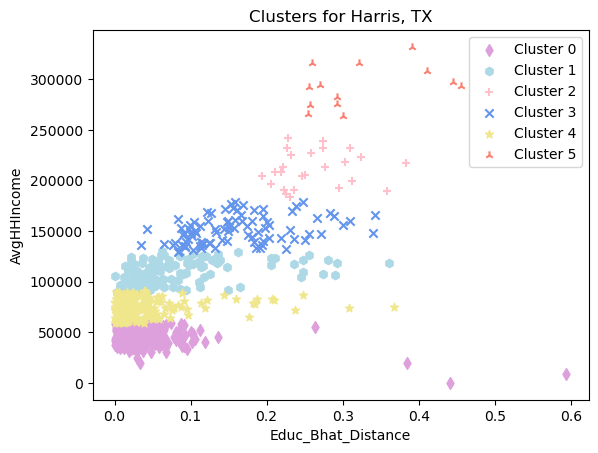

NOT FINISHED.. Wait for re-grouping to original cluster 48201
how many clusters there should be: 6
0    278
4    242
1    139
3     89
2     25
5     13
Name: cluster, dtype: int64


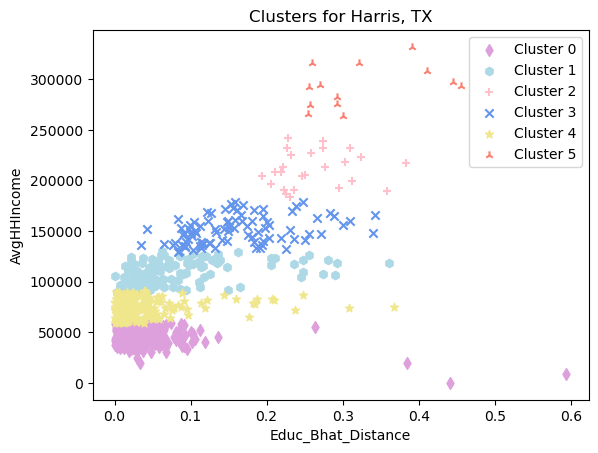

--
Harrison, TX
(1572, 17)
Amount of available data points for Harrison, TX: 1572
Amount of available data points after merging with 48201: 1572


area.shape
(1572, 10)
(786, 10)
X shape
(786, 8)


,TransportWarehouseInd,Manufacturing,AvgHHIncome,AvgDIncome,Age_Bhat_Distance,Gender_Bhat_Distance,Educ_Bhat_Distance,Race_Bhat_Distance
1677,251.0,441.0,137949,97553,0.951014,0.007899,0.543106,0.334239
1678,2.0,4.0,152334,110150,0.906539,0.014497,0.201197,0.456057
1679,94.0,191.0,41961,35619,1.183812,0.029832,0.383186,0.388291
1680,128.0,233.0,47845,39809,1.121317,0.031970,0.319170,0.352616
1681,302.0,219.0,73778,60652,1.205601,0.031143,0.281418,0.220154
...,...,...,...,...,...,...,...,...
2458,373.0,649.0,136310,103703,1.166914,0.035429,0.326176,0.166336
2459,305.0,612.0,152317,113061,1.216753,0.036116,0.525503,0.142395
2460,244.0,491.0,91679,70731,1.166219,0.035252,0.201518,0.279372
2461,0.0,0.0,8525,8421,1.225503,0.009684,0.423649,0.282164


hyperparameter tuning? False
Parameters in use:
algorithm: auto
initializing with: k-means++
clusters: 6


C:\Users\kzhang\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\kzhang\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


[[1.55949640e+02 1.81348921e+02 4.66918777e+04 3.94514460e+04
  1.10239020e+00 3.42665431e-02 3.19319497e-01 5.88979149e-01]
 [2.27273381e+02 4.05021583e+02 1.07458849e+05 8.27855180e+04
  1.18194499e+00 3.66719158e-02 4.05635013e-01 2.44220497e-01]
 [6.78400000e+01 1.71400000e+02 2.10979800e+05 1.39744400e+05
  1.45021598e+00 3.79160286e-02 8.68265421e-01 1.60001521e-01]
 [2.00528090e+02 4.07022472e+02 1.51033472e+05 1.09233854e+05
  1.24132111e+00 3.52644950e-02 6.16050415e-01 1.93969050e-01]
 [2.24442149e+02 3.00991736e+02 7.26123719e+04 5.91841694e+04
  1.10726744e+00 3.66630165e-02 3.18401296e-01 4.12474395e-01]
 [3.56153846e+01 1.37000000e+02 2.93114462e+05 1.81988462e+05
  1.74195458e+00 3.71950309e-02 1.03470092e+00 1.17356513e-01]]
Centroid 0: label 0
Centroid 1: label 1
Centroid 2: label 2
Centroid 3: label 3
Centroid 4: label 4
Centroid 5: label 5


C:\Users\kzhang\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


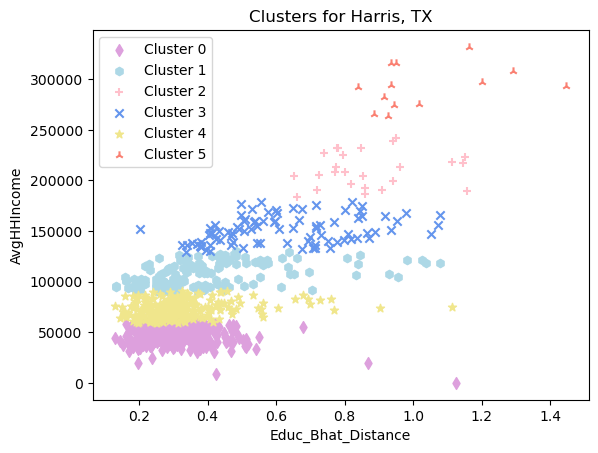

NOT FINISHED.. Wait for re-grouping to original cluster 48201
how many clusters there should be: 6
0    278
4    242
1    139
3     89
2     25
5     13
Name: cluster, dtype: int64


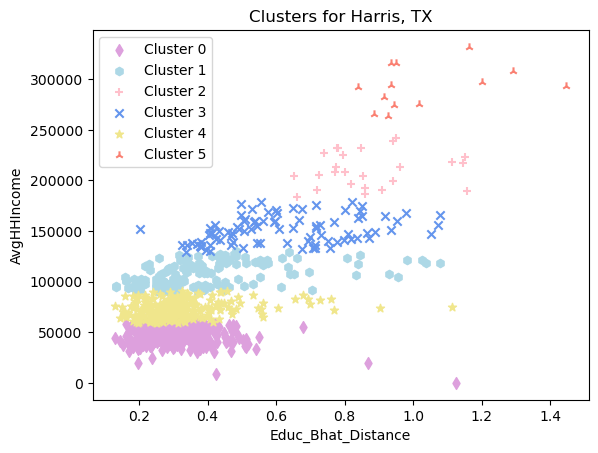

--
Brazoria, TX
(50, 17)
Amount of available data points for Brazoria, TX: 50
Amount of available data points after merging with 48201: 50


area.shape
(50, 10)
(50, 10)
X shape
(50, 8)


,TransportWarehouseInd,Manufacturing,AvgHHIncome,AvgDIncome,Age_Bhat_Distance,Gender_Bhat_Distance,Educ_Bhat_Distance,Race_Bhat_Distance
1478,155.0,183.0,128912,99831,0.039364,0.000850,0.042329,0.038610
1479,147.0,354.0,109740,85612,0.024955,0.000421,0.026823,0.028370
1480,63.0,775.0,116410,91267,0.018803,0.001071,0.050325,0.020335
1481,507.0,756.0,116967,90485,0.017019,0.001451,0.051573,0.035848
1482,425.0,664.0,102688,81008,0.023737,0.000320,0.022871,0.068153
1483,358.0,589.0,126729,96952,0.037781,0.001804,0.043393,0.039128
1484,1290.0,2359.0,123441,95521,0.033150,0.000991,0.067085,0.087356
1485,333.0,984.0,139120,103786,0.023009,0.001337,0.107209,0.039293
1486,222.0,657.0,128900,96764,0.027105,0.000463,0.095817,0.021119
1487,190.0,589.0,111939,89354,0.020878,0.001005,0.044498,0.033206


hyperparameter tuning? False
Parameters in use:
algorithm: auto
initializing with: k-means++
clusters: 6


C:\Users\kzhang\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\kzhang\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


[[1.10166667e+02 3.09666667e+02 7.50584167e+04 6.15320833e+04
  2.81972058e-02 5.06488699e-04 8.88403033e-03 7.05292507e-02]
 [2.29500000e+02 4.82400000e+02 1.06504200e+05 8.34503000e+04
  2.72300757e-02 1.29582652e-03 2.03525311e-02 5.89226812e-02]
 [1.51333333e+02 8.46333333e+02 1.42066000e+05 1.06221000e+05
  3.53468108e-02 6.86132612e-04 6.25657854e-02 3.95849067e-02]
 [1.21571429e+02 4.06928571e+02 9.06639286e+04 7.19027143e+04
  2.73662942e-02 4.77796064e-04 6.53034565e-03 6.70845017e-02]
 [4.65000000e+01 1.53000000e+02 5.77487500e+04 4.81780000e+04
  2.29365066e-02 4.21406116e-04 2.34831973e-02 9.43558189e-02]
 [3.85571429e+02 8.77142857e+02 1.23748143e+05 9.56568571e+04
  2.77412178e-02 1.04770993e-03 5.54873158e-02 3.91767623e-02]]
Centroid 0: label 0
Centroid 1: label 1
Centroid 2: label 2
Centroid 3: label 3
Centroid 4: label 4
Centroid 5: label 5


C:\Users\kzhang\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


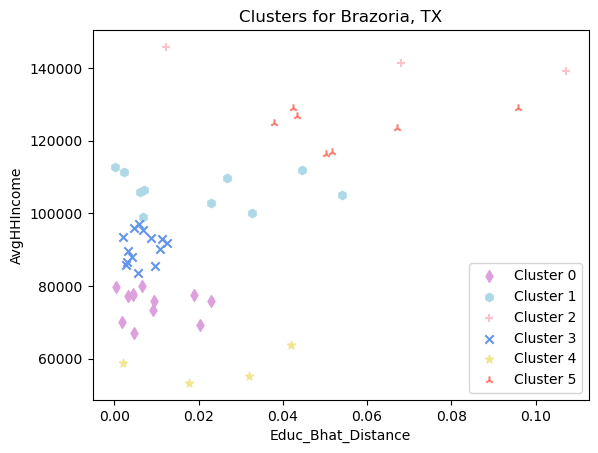

NOT FINISHED.. Wait for re-grouping to original cluster 48201
how many clusters there should be: 6
1    31
4    12
0     4
3     3
Name: cluster, dtype: int64


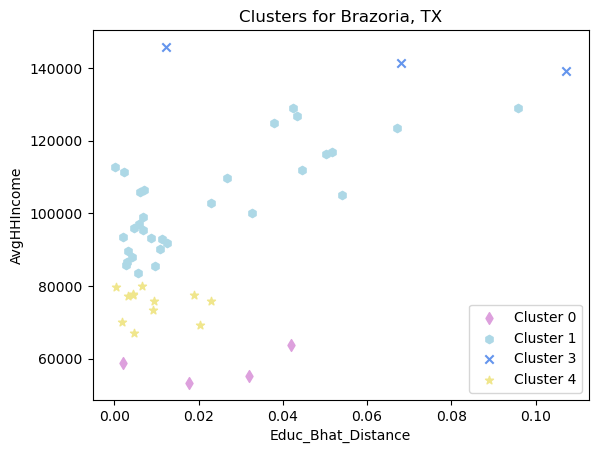

--
Chambers, TX
(5, 17)
Amount of available data points for Chambers, TX: 5
Using 48201 County warehouse demo data
Amount of available data points after merging with 48201: 71


area.shape
(71, 10)
(71, 10)
X shape
(71, 8)


,TransportWarehouseInd,Manufacturing,AvgHHIncome,AvgDIncome,Age_Bhat_Distance,Gender_Bhat_Distance,Educ_Bhat_Distance,Race_Bhat_Distance
1528,303.0,1080.0,129497,95535,0.093591,0.014721,0.025989,0.099019
1529,721.0,1621.0,121036,94403,0.077732,0.012934,0.038796,0.085463
1530,38.0,105.0,101139,77553,0.114278,0.014303,0.011096,0.029211
1531,241.0,387.0,78227,62242,0.100295,0.013642,0.011591,0.110990
1532,136.0,163.0,62442,51601,0.095978,0.010745,0.025025,0.143802
...,...,...,...,...,...,...,...,...
1671,69.0,113.0,76049,60081,0.088123,0.014530,0.004321,0.070398
1672,19.0,30.0,66285,53746,0.063879,0.015071,0.051222,0.064792
1673,35.0,34.0,101564,79744,0.167817,0.012975,0.035283,0.099620
1674,48.0,54.0,119679,90726,0.210288,0.011823,0.070927,0.115329


hyperparameter tuning? False
Parameters in use:
algorithm: auto
initializing with: k-means++
clusters: 6


C:\Users\kzhang\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\kzhang\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


[[5.39285714e+01 4.85714286e+01 5.26917857e+04 4.40980714e+04
  1.04299770e-01 1.56278275e-02 1.58980543e-02 8.57945735e-02]
 [1.52333333e+02 5.30833333e+02 1.41933167e+05 1.05393833e+05
  1.12650270e-01 1.57635957e-02 9.19283909e-02 9.21655515e-02]
 [1.05866667e+02 1.94733333e+02 9.25180000e+04 7.30588000e+04
  1.09939480e-01 1.42731987e-02 1.99539134e-02 9.73996122e-02]
 [2.51000000e+02 8.08000000e+02 2.18644000e+05 1.51262000e+05
  9.72722679e-02 1.34983621e-02 1.66780856e-01 1.02795318e-01]
 [9.50000000e+01 1.64380952e+02 6.91388095e+04 5.62750476e+04
  9.84332248e-02 1.35614744e-02 1.61439754e-02 9.22581175e-02]
 [2.68642857e+02 5.83000000e+02 1.22665214e+05 9.39614286e+04
  1.15859088e-01 1.43043304e-02 6.96181644e-02 7.57299673e-02]]
Centroid 0: label 0
Centroid 1: label 1
Centroid 2: label 2
Centroid 3: label 3
Centroid 4: label 4
Centroid 5: label 5


C:\Users\kzhang\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


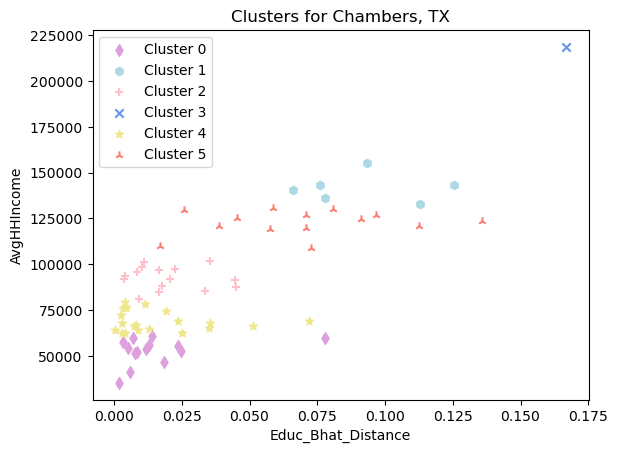

NOT FINISHED.. Wait for re-grouping to original cluster 48201
how many clusters there should be: 6
1    29
4    21
0    14
3     6
2     1
Name: cluster, dtype: int64


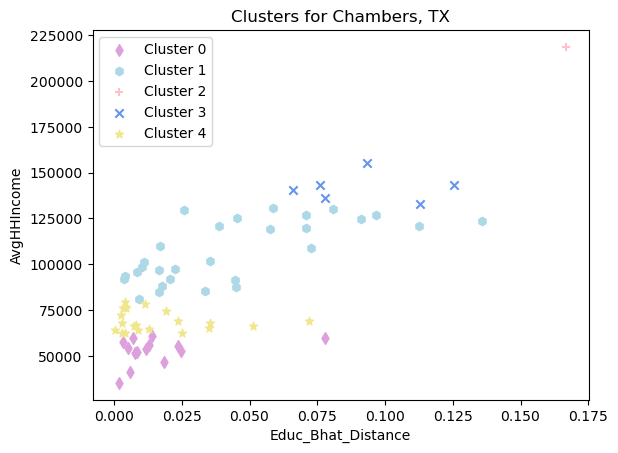

--
Fort Bend, TX
(76, 17)
Amount of available data points for Fort Bend, TX: 76
Amount of available data points after merging with 48201: 76


area.shape
(76, 10)
(76, 10)
X shape
(76, 8)


,TransportWarehouseInd,Manufacturing,AvgHHIncome,AvgDIncome,Age_Bhat_Distance,Gender_Bhat_Distance,Educ_Bhat_Distance,Race_Bhat_Distance
1534,191.0,202.0,58155,49159,0.074905,0.000362,0.024403,0.081367
1535,209.0,81.0,60738,51167,0.085953,0.000846,0.008554,0.089936
1536,282.0,170.0,64369,54126,0.092141,0.000618,0.017958,0.089134
1537,198.0,159.0,61090,51560,0.116662,0.000746,0.011380,0.139349
1538,272.0,27.0,69223,57734,0.102737,0.002025,0.011621,0.199504
...,...,...,...,...,...,...,...,...
1605,112.0,622.0,74397,62028,0.097795,0.000235,0.000138,0.190208
1606,537.0,1203.0,119017,90496,0.077736,0.000378,0.024259,0.046687
1607,257.0,257.0,98260,77320,0.118041,0.000095,0.008775,0.213093
1608,171.0,445.0,86574,68213,0.116189,0.000167,0.005483,0.140394


hyperparameter tuning? False
Parameters in use:
algorithm: auto
initializing with: k-means++
clusters: 6


C:\Users\kzhang\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\kzhang\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


[[2.29916667e+02 5.34750000e+02 1.48446000e+05 1.09350083e+05
  1.21220211e-01 4.62279482e-04 9.84871257e-02 8.69869601e-02]
 [1.88500000e+02 2.14916667e+02 6.60688333e+04 5.49765417e+04
  8.86498170e-02 5.69493150e-04 1.69127017e-02 1.17641337e-01]
 [3.22916667e+02 5.25416667e+02 1.21447917e+05 9.26873333e+04
  1.18809824e-01 4.78713327e-04 6.54297604e-02 9.40989578e-02]
 [2.88250000e+02 8.01416667e+02 1.88916083e+05 1.33385583e+05
  1.50287079e-01 4.25259490e-04 1.41173874e-01 1.42225796e-01]
 [2.70000000e+01 3.65000000e+02 2.78544000e+05 1.78000000e+05
  2.10503288e-01 3.09356865e-04 2.47733296e-01 1.83842532e-01]
 [1.88800000e+02 2.91800000e+02 9.20507333e+04 7.37269333e+04
  9.93188725e-02 1.51681567e-02 3.02108709e-02 1.19344122e-01]]
Centroid 0: label 0
Centroid 1: label 1
Centroid 2: label 2
Centroid 3: label 3
Centroid 4: label 4
Centroid 5: label 5


C:\Users\kzhang\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


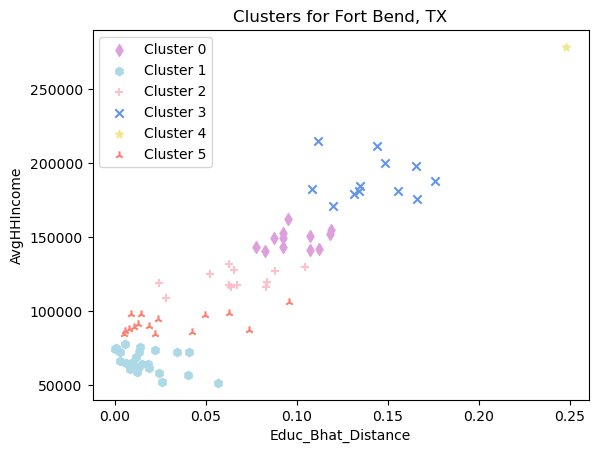

NOT FINISHED.. Wait for re-grouping to original cluster 48201
how many clusters there should be: 6
1    27
4    24
3    12
2    12
5     1
Name: cluster, dtype: int64


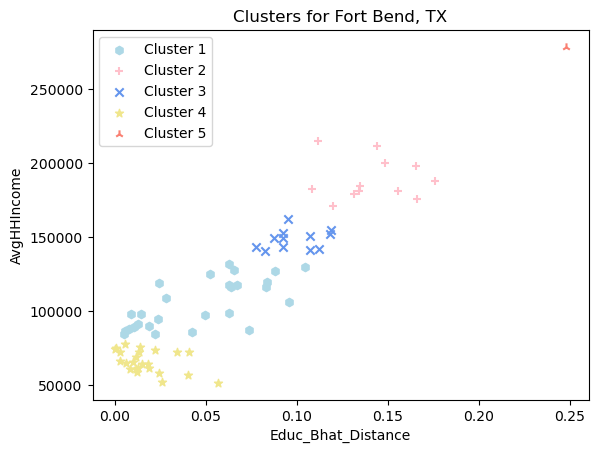

--
Galveston, TX
(66, 17)
Amount of available data points for Galveston, TX: 66
Amount of available data points after merging with 48201: 66


area.shape
(66, 10)
(66, 10)
X shape
(66, 8)


,TransportWarehouseInd,Manufacturing,AvgHHIncome,AvgDIncome,Age_Bhat_Distance,Gender_Bhat_Distance,Educ_Bhat_Distance,Race_Bhat_Distance
1610,67.0,258.0,143488,103874,0.110268,0.016540,0.076000,0.108847
1611,174.0,283.0,143298,104023,0.152071,0.017529,0.125387,0.103042
1612,28.0,186.0,135906,100015,0.143022,0.016369,0.077934,0.118086
1613,211.0,320.0,155205,114571,0.119329,0.015710,0.093321,0.101440
1614,251.0,808.0,218644,151262,0.097272,0.013498,0.166781,0.102795
...,...,...,...,...,...,...,...,...
1671,69.0,113.0,76049,60081,0.088123,0.014530,0.004321,0.070398
1672,19.0,30.0,66285,53746,0.063879,0.015071,0.051222,0.064792
1673,35.0,34.0,101564,79744,0.167817,0.012975,0.035283,0.099620
1674,48.0,54.0,119679,90726,0.210288,0.011823,0.070927,0.115329


hyperparameter tuning? False
Parameters in use:
algorithm: auto
initializing with: k-means++
clusters: 6


C:\Users\kzhang\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\kzhang\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


[[1.52333333e+02 5.30833333e+02 1.41933167e+05 1.05393833e+05
  1.12650270e-01 1.57635957e-02 9.19283909e-02 9.21655515e-02]
 [8.51578947e+01 1.52736842e+02 6.90129474e+04 5.62070000e+04
  9.84644689e-02 1.37054746e-02 1.59161702e-02 8.85594015e-02]
 [1.10714286e+02 2.01142857e+02 9.19022143e+04 7.27377857e+04
  1.09629618e-01 1.42710942e-02 2.05866379e-02 1.02270243e-01]
 [2.51000000e+02 8.08000000e+02 2.18644000e+05 1.51262000e+05
  9.72722679e-02 1.34983621e-02 1.66780856e-01 1.02795318e-01]
 [5.39285714e+01 4.85714286e+01 5.26917857e+04 4.40980714e+04
  1.04299770e-01 1.56278275e-02 1.58980543e-02 8.57945735e-02]
 [2.28083333e+02 4.55083333e+02 1.22231667e+05 9.37935000e+04
  1.20891989e-01 1.43838305e-02 7.58223730e-02 7.29781384e-02]]
Centroid 0: label 0
Centroid 1: label 1
Centroid 2: label 2
Centroid 3: label 3
Centroid 4: label 4
Centroid 5: label 5


C:\Users\kzhang\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


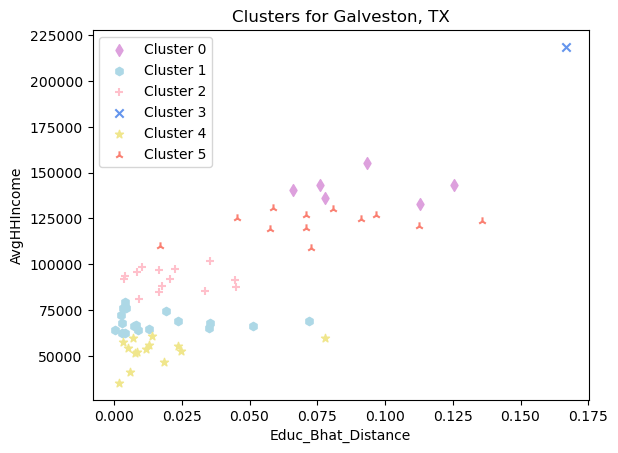

NOT FINISHED.. Wait for re-grouping to original cluster 48201
how many clusters there should be: 6
1    26
4    19
0    14
3     6
2     1
Name: cluster, dtype: int64


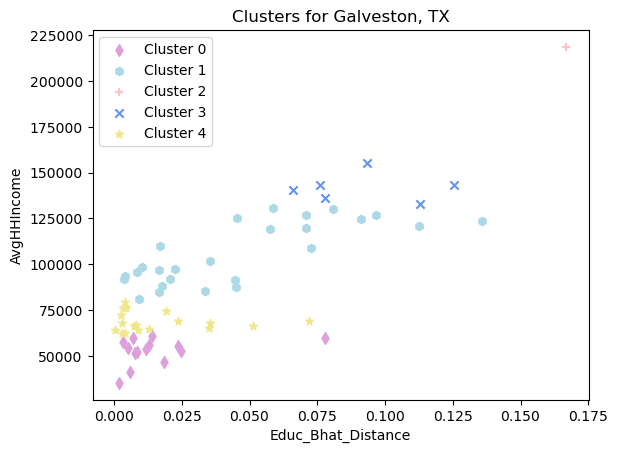

--
Austin, TX
(6, 17)
Amount of available data points for Austin, TX: 6
Using 48201 County warehouse demo data
Amount of available data points after merging with 48201: 72


area.shape
(72, 10)
(72, 10)
X shape
(72, 8)


,TransportWarehouseInd,Manufacturing,AvgHHIncome,AvgDIncome,Age_Bhat_Distance,Gender_Bhat_Distance,Educ_Bhat_Distance,Race_Bhat_Distance
1472,19.0,175.0,64388,54312,0.101766,0.014020,0.006528,0.080723
1473,160.0,445.0,80406,65393,0.097805,0.012063,0.002652,0.070691
1474,176.0,332.0,81352,67772,0.103191,0.015179,0.002190,0.100982
1475,184.0,272.0,87105,69789,0.148950,0.013790,0.022448,0.089583
1476,162.0,222.0,105764,84181,0.159322,0.013161,0.038012,0.078706
...,...,...,...,...,...,...,...,...
1671,69.0,113.0,76049,60081,0.088123,0.014530,0.004321,0.070398
1672,19.0,30.0,66285,53746,0.063879,0.015071,0.051222,0.064792
1673,35.0,34.0,101564,79744,0.167817,0.012975,0.035283,0.099620
1674,48.0,54.0,119679,90726,0.210288,0.011823,0.070927,0.115329


hyperparameter tuning? False
Parameters in use:
algorithm: auto
initializing with: k-means++
clusters: 6


C:\Users\kzhang\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\kzhang\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


[[8.35217391e+01 1.47652174e+02 6.79413478e+04 5.55253913e+04
  9.94396525e-02 1.41382328e-02 1.47072305e-02 8.31971247e-02]
 [2.23636364e+02 4.55000000e+02 1.19241091e+05 9.18615455e+04
  1.25098771e-01 1.38603122e-02 7.35024187e-02 7.46095827e-02]
 [2.51000000e+02 8.08000000e+02 2.18644000e+05 1.51262000e+05
  9.72722679e-02 1.34983621e-02 1.66780856e-01 1.02795318e-01]
 [1.21764706e+02 2.27352941e+02 9.03231765e+04 7.18401765e+04
  1.10868308e-01 1.41662996e-02 1.85590091e-02 9.95905263e-02]
 [1.69125000e+02 4.82875000e+02 1.39061375e+05 1.03948625e+05
  1.13730085e-01 1.59856600e-02 8.63655360e-02 8.58413929e-02]
 [4.44166667e+01 5.25833333e+01 5.14294167e+04 4.31675000e+04
  1.04078417e-01 1.53116724e-02 1.67875672e-02 9.28780381e-02]]
Centroid 0: label 0
Centroid 1: label 1
Centroid 2: label 2
Centroid 3: label 3
Centroid 4: label 4
Centroid 5: label 5


C:\Users\kzhang\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


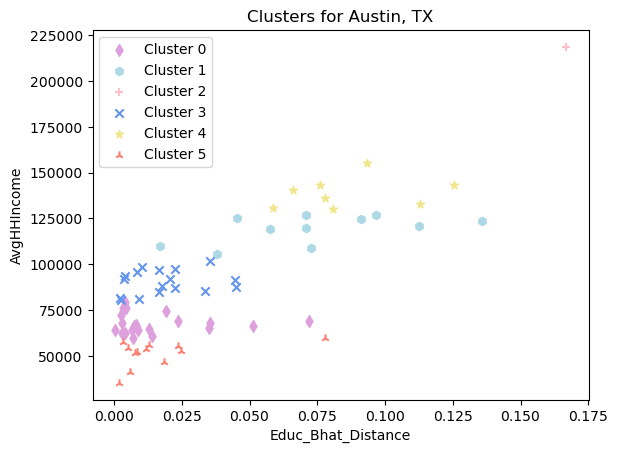

NOT FINISHED.. Wait for re-grouping to original cluster 48201
how many clusters there should be: 6
1    28
4    23
0    12
3     8
2     1
Name: cluster, dtype: int64


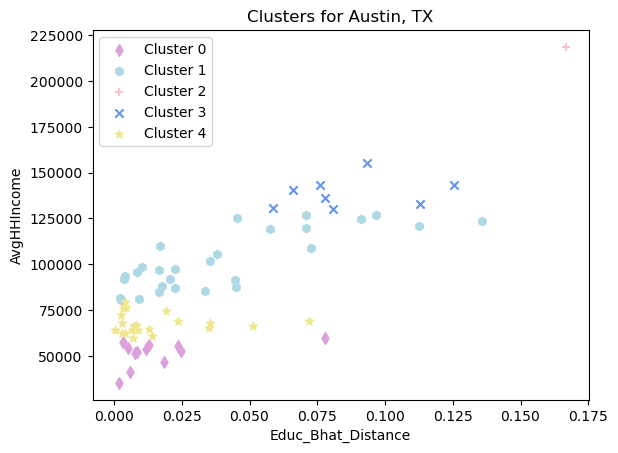

--
Liberty, TX
(0, 17)
Amount of available data points for Liberty, TX: 0
Using 48201 County warehouse demo data
Amount of available data points after merging with 48201: 66


area.shape
(66, 10)
(66, 10)
X shape
(66, 8)


,TransportWarehouseInd,Manufacturing,AvgHHIncome,AvgDIncome,Age_Bhat_Distance,Gender_Bhat_Distance,Educ_Bhat_Distance,Race_Bhat_Distance
1610,67.0,258.0,143488,103874,0.110268,0.016540,0.076000,0.108847
1611,174.0,283.0,143298,104023,0.152071,0.017529,0.125387,0.103042
1612,28.0,186.0,135906,100015,0.143022,0.016369,0.077934,0.118086
1613,211.0,320.0,155205,114571,0.119329,0.015710,0.093321,0.101440
1614,251.0,808.0,218644,151262,0.097272,0.013498,0.166781,0.102795
...,...,...,...,...,...,...,...,...
1671,69.0,113.0,76049,60081,0.088123,0.014530,0.004321,0.070398
1672,19.0,30.0,66285,53746,0.063879,0.015071,0.051222,0.064792
1673,35.0,34.0,101564,79744,0.167817,0.012975,0.035283,0.099620
1674,48.0,54.0,119679,90726,0.210288,0.011823,0.070927,0.115329


hyperparameter tuning? False
Parameters in use:
algorithm: auto
initializing with: k-means++
clusters: 6


C:\Users\kzhang\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\kzhang\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


[[1.52333333e+02 5.30833333e+02 1.41933167e+05 1.05393833e+05
  1.12650270e-01 1.57635957e-02 9.19283909e-02 9.21655515e-02]
 [8.51578947e+01 1.52736842e+02 6.90129474e+04 5.62070000e+04
  9.84644689e-02 1.37054746e-02 1.59161702e-02 8.85594015e-02]
 [1.10714286e+02 2.01142857e+02 9.19022143e+04 7.27377857e+04
  1.09629618e-01 1.42710942e-02 2.05866379e-02 1.02270243e-01]
 [2.51000000e+02 8.08000000e+02 2.18644000e+05 1.51262000e+05
  9.72722679e-02 1.34983621e-02 1.66780856e-01 1.02795318e-01]
 [5.39285714e+01 4.85714286e+01 5.26917857e+04 4.40980714e+04
  1.04299770e-01 1.56278275e-02 1.58980543e-02 8.57945735e-02]
 [2.28083333e+02 4.55083333e+02 1.22231667e+05 9.37935000e+04
  1.20891989e-01 1.43838305e-02 7.58223730e-02 7.29781384e-02]]


C:\Users\kzhang\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


Centroid 0: label 0
Centroid 1: label 1
Centroid 2: label 2
Centroid 3: label 3
Centroid 4: label 4
Centroid 5: label 5


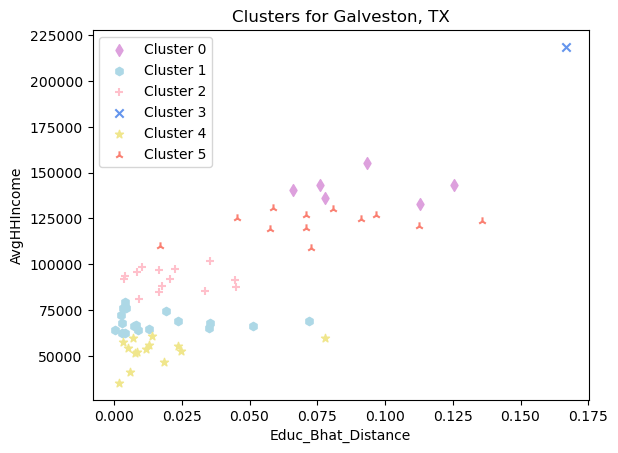

NOT FINISHED.. Wait for re-grouping to original cluster 48201
how many clusters there should be: 6
1    26
4    19
0    14
3     6
2     1
Name: cluster, dtype: int64


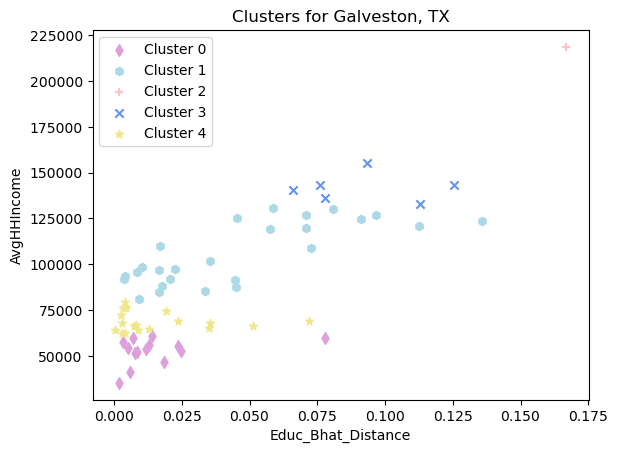

--
Montgomery, TX
(59, 17)
Amount of available data points for Montgomery, TX: 59
Amount of available data points after merging with 48201: 59


area.shape
(59, 10)
(59, 10)
X shape
(59, 8)


,TransportWarehouseInd,Manufacturing,AvgHHIncome,AvgDIncome,Age_Bhat_Distance,Gender_Bhat_Distance,Educ_Bhat_Distance,Race_Bhat_Distance
2477,310.0,571.0,105932,83069,0.036899,0.000276,0.003283,0.115378
2478,246.0,662.0,122888,93522,0.043901,0.000273,0.038303,0.077395
2479,275.0,488.0,124609,95650,0.055498,0.000558,0.030197,0.105523
2480,171.0,346.0,78733,61338,0.049987,0.000211,0.006105,0.065133
2481,207.0,249.0,151038,112236,0.031100,0.000257,0.045847,0.045701
2482,426.0,1040.0,137798,100817,0.036098,0.000366,0.027843,0.096277
2483,727.0,746.0,165579,120492,0.054310,0.000291,0.097213,0.073920
2484,372.0,1277.0,138321,103395,0.041437,0.000180,0.161737,0.065197
2485,432.0,1059.0,204862,141081,0.042106,0.000239,0.218855,0.052510
2486,311.0,346.0,122440,93054,0.101228,0.000182,0.075166,0.035251


hyperparameter tuning? False
Parameters in use:
algorithm: auto
initializing with: k-means++
clusters: 6


C:\Users\kzhang\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\kzhang\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


[[3.54333333e+02 4.28400000e+02 1.17405800e+05 8.95522000e+04
  5.40131599e-02 3.26353773e-04 6.22890293e-02 5.57784069e-02]
 [4.30833333e+02 5.66500000e+02 1.79806167e+05 1.27811500e+05
  6.02282794e-02 2.37982689e-04 1.51894261e-01 5.82987717e-02]
 [3.49000000e+02 3.96357143e+02 8.95842857e+04 7.04435714e+04
  4.46708811e-02 3.47080981e-04 2.36375988e-02 7.23488939e-02]
 [1.58750000e+02 4.06000000e+02 2.22073750e+05 1.48751500e+05
  6.78871525e-02 3.11978355e-04 2.53104896e-01 6.54800141e-02]
 [1.43000000e+02 3.14230769e+02 6.93198462e+04 5.58928462e+04
  3.55300732e-02 5.95013469e-04 1.52846914e-02 8.79901045e-02]
 [4.28285714e+02 7.37571429e+02 1.43597714e+05 1.06391571e+05
  5.07676978e-02 2.22228321e-04 9.41141908e-02 6.16290045e-02]]


C:\Users\kzhang\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


Centroid 0: label 0
Centroid 1: label 1
Centroid 2: label 2
Centroid 3: label 3
Centroid 4: label 4
Centroid 5: label 5


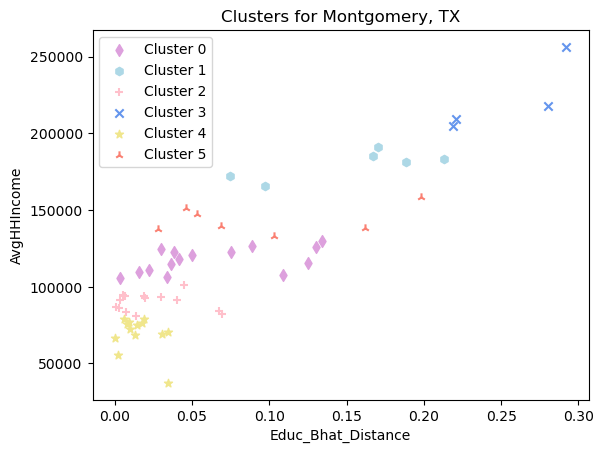

NOT FINISHED.. Wait for re-grouping to original cluster 48201
how many clusters there should be: 6
4    27
1    15
2    10
3     7
Name: cluster, dtype: int64


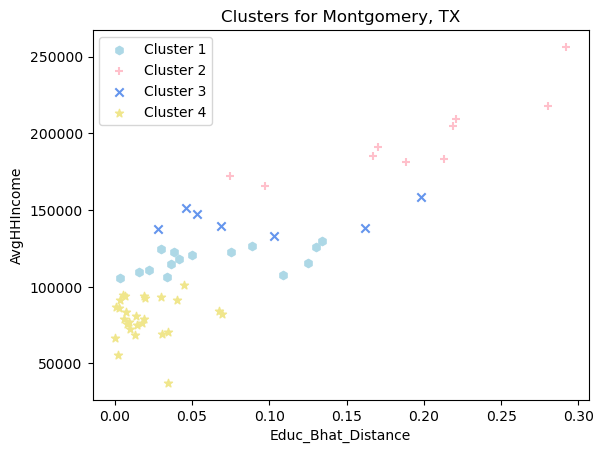

--
Waller, TX
(6, 17)
Amount of available data points for Waller, TX: 6
Using 48201 County warehouse demo data
Amount of available data points after merging with 48201: 72


area.shape
(72, 10)
(72, 10)
X shape
(72, 8)


,TransportWarehouseInd,Manufacturing,AvgHHIncome,AvgDIncome,Age_Bhat_Distance,Gender_Bhat_Distance,Educ_Bhat_Distance,Race_Bhat_Distance
1610,67.0,258.0,143488,103874,0.110268,0.016540,0.076000,0.108847
1611,174.0,283.0,143298,104023,0.152071,0.017529,0.125387,0.103042
1612,28.0,186.0,135906,100015,0.143022,0.016369,0.077934,0.118086
1613,211.0,320.0,155205,114571,0.119329,0.015710,0.093321,0.101440
1614,251.0,808.0,218644,151262,0.097272,0.013498,0.166781,0.102795
...,...,...,...,...,...,...,...,...
2537,256.0,732.0,72479,58114,0.087789,0.011966,0.006720,0.095253
2538,198.0,329.0,71408,57190,0.080289,0.013704,0.004726,0.070423
2539,0.0,0.0,0,0,1.116131,0.028277,0.212416,0.425960
2540,205.0,472.0,65952,53020,0.096867,0.012971,0.005560,0.089226


hyperparameter tuning? False
Parameters in use:
algorithm: auto
initializing with: k-means++
clusters: 6


C:\Users\kzhang\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\kzhang\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


[[1.06043478e+02 2.03000000e+02 6.96591739e+04 5.66539130e+04
  9.72526999e-02 1.36210614e-02 1.42811637e-02 8.65518506e-02]
 [2.16941176e+02 5.04764706e+02 1.31417824e+05 9.93974706e+04
  1.12486450e-01 1.49752303e-02 8.38909504e-02 8.43641601e-02]
 [5.39285714e+01 4.85714286e+01 5.26917857e+04 4.40980714e+04
  1.04299770e-01 1.56278275e-02 1.58980543e-02 8.57945735e-02]
 [1.08125000e+02 2.31937500e+02 9.56748125e+04 7.52218125e+04
  1.14745675e-01 1.41376941e-02 2.33956798e-02 1.04870803e-01]
 [2.51000000e+02 8.08000000e+02 2.18644000e+05 1.51262000e+05
  9.72722679e-02 1.34983621e-02 1.66780856e-01 1.02795318e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.11613129e+00 2.82771990e-02 2.12415580e-01 4.25959770e-01]]
Centroid 0: label 0
Centroid 1: label 1
Centroid 2: label 2
Centroid 3: label 3
Centroid 4: label 4
Centroid 5: label 5


C:\Users\kzhang\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


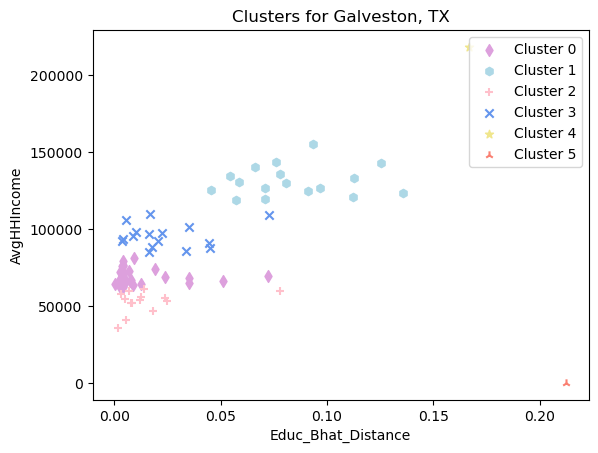

NOT FINISHED.. Wait for re-grouping to original cluster 48201
how many clusters there should be: 6
4    23
3    17
1    16
0    15
2     1
Name: cluster, dtype: int64


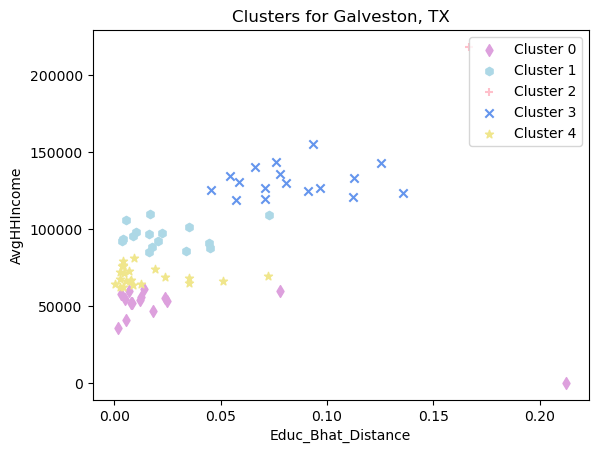

48425.0
48497.0
{48113: 'Dallas, TX', 48085: 'Collin, TX', 48121: 'Denton, TX', 48139: 'Ellis, TX', 48221: 'Hood, TX', 48231: 'Hunt, TX', 48251: 'Johnson, TX', 48257: 'Kaufman, TX', 48367: 'Parker, TX', 48397: 'Rockwall, TX', 48439: 'Tarrant, TX'}
--
Dallas, TX
(528, 17)
Amount of available data points for Dallas, TX: 528
Amount of available data points after merging with 48113: 528


area.shape
(528, 10)
(528, 10)
X shape
(528, 8)


,TransportWarehouseInd,Manufacturing,AvgHHIncome,AvgDIncome,Age_Bhat_Distance,Gender_Bhat_Distance,Educ_Bhat_Distance,Race_Bhat_Distance
152,48.0,92.0,201352,134712,0.090824,0.001183,0.219939,0.115791
153,77.0,167.0,211310,142140,0.085613,0.004008,0.251389,0.132945
154,200.0,87.0,150335,105457,0.040899,0.001118,0.201850,0.126894
155,112.0,40.0,164031,112870,0.022492,0.000370,0.229551,0.098617
156,109.0,339.0,67946,55450,0.029167,0.000142,0.022247,0.100333
...,...,...,...,...,...,...,...,...
675,399.0,572.0,93457,74334,0.024477,0.000289,0.055042,0.023376
676,127.0,115.0,30274,25781,0.091083,0.004862,0.018854,0.095355
677,0.0,57.0,301819,188933,0.213689,0.000707,0.337770,0.140576
678,85.0,349.0,106761,81991,0.095651,0.002638,0.073528,0.062763


hyperparameter tuning? False
Parameters in use:
algorithm: auto
initializing with: k-means++
clusters: 6


C:\Users\kzhang\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\kzhang\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


[[3.99545455e+01 7.50909091e+01 2.71574318e+05 1.72100091e+05
  1.63102482e-01 1.59386349e-03 3.51134920e-01 1.42229721e-01]
 [2.00939024e+02 2.51390244e+02 6.66902500e+04 5.50774329e+04
  5.00450558e-02 1.25208572e-03 2.87063449e-02 1.27172977e-01]
 [1.77333333e+02 2.32407407e+02 1.30645722e+05 9.73242778e+04
  7.97232929e-02 1.18747358e-03 1.52525189e-01 8.92790421e-02]
 [8.57222222e+01 1.53083333e+02 1.80558417e+05 1.25265972e+05
  1.18641629e-01 1.58687497e-03 2.26161176e-01 1.10601123e-01]
 [1.49104478e+02 1.75500000e+02 4.59359104e+04 3.89153134e+04
  5.77804587e-02 1.53141169e-03 3.29233414e-02 1.75775481e-01]
 [1.84355932e+02 2.49974576e+02 9.21035085e+04 7.33620169e+04
  6.36723163e-02 1.58445549e-03 5.66765715e-02 8.40917440e-02]]


C:\Users\kzhang\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


Centroid 0: label 0
Centroid 1: label 1
Centroid 2: label 2
Centroid 3: label 3
Centroid 4: label 4
Centroid 5: label 5


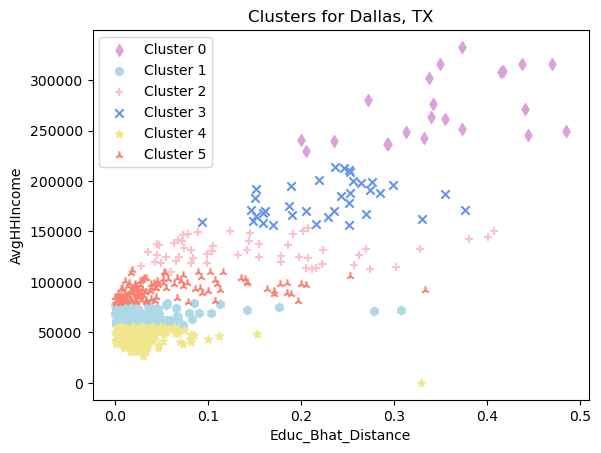

NOT FINISHED.. Wait for re-grouping to original cluster 48113
how many clusters there should be: 6
4    164
0    134
1    118
3     90
5     22
Name: cluster, dtype: int64


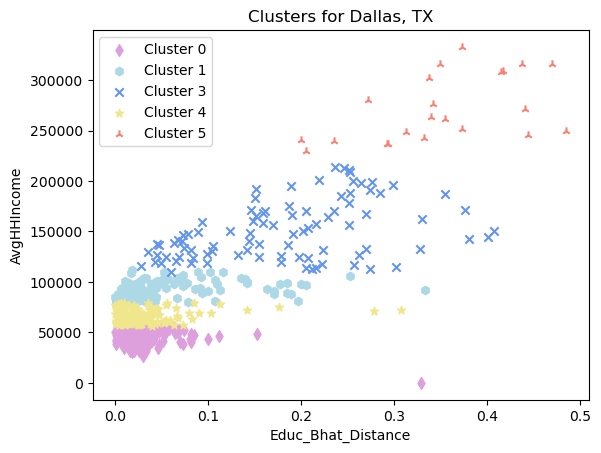

--
Collin, TX
(152, 17)
Amount of available data points for Collin, TX: 152
Amount of available data points after merging with 48113: 152


area.shape
(152, 10)
(152, 10)
X shape
(152, 8)


,TransportWarehouseInd,Manufacturing,AvgHHIncome,AvgDIncome,Age_Bhat_Distance,Gender_Bhat_Distance,Educ_Bhat_Distance,Race_Bhat_Distance
0,206.0,130.0,91700,74004,0.056842,0.004512,0.029904,0.035178
1,92.0,233.0,94726,73506,0.071501,0.005472,0.064641,0.060514
2,70.0,207.0,111216,88513,0.080933,0.004840,0.070832,0.054693
3,66.0,86.0,98203,78932,0.070223,0.003875,0.031576,0.030665
4,135.0,100.0,79089,64603,0.034415,0.003066,0.028139,0.036164
...,...,...,...,...,...,...,...,...
147,77.0,116.0,134267,102636,0.131320,0.004348,0.095463,0.059511
148,45.0,185.0,113099,87738,0.119441,0.003941,0.049186,0.043813
149,58.0,184.0,101488,81190,0.103467,0.004855,0.037588,0.041194
150,19.0,68.0,88296,71366,0.084610,0.003565,0.032514,0.048056


hyperparameter tuning? False
Parameters in use:
algorithm: auto
initializing with: k-means++
clusters: 6


C:\Users\kzhang\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\kzhang\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


[[9.67291667e+01 3.01708333e+02 1.24731458e+05 9.50244792e+04
  7.81650067e-02 4.32729988e-03 9.33625147e-02 4.18217534e-02]
 [1.57054054e+02 3.02783784e+02 9.73051081e+04 7.69828919e+04
  6.27869903e-02 3.90026947e-03 6.35050433e-02 6.41600587e-02]
 [1.60000000e+01 5.90000000e+01 2.94683000e+05 1.85069000e+05
  2.23471197e-01 2.99633443e-03 2.08222578e-01 6.55356780e-02]
 [1.30750000e+02 4.21312500e+02 1.95628688e+05 1.37860062e+05
  1.00864442e-01 3.74488443e-03 1.77264651e-01 9.96354966e-02]
 [1.01772727e+02 2.24318182e+02 7.09458182e+04 5.77780000e+04
  5.84077821e-02 3.45806908e-03 3.62981892e-02 6.29732217e-02]
 [1.13142857e+02 3.25107143e+02 1.54120643e+05 1.13340571e+05
  8.81809558e-02 4.08800046e-03 1.26883275e-01 8.10800470e-02]]
Centroid 0: label 0
Centroid 1: label 1
Centroid 2: label 2
Centroid 3: label 3
Centroid 4: label 4
Centroid 5: label 5


C:\Users\kzhang\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


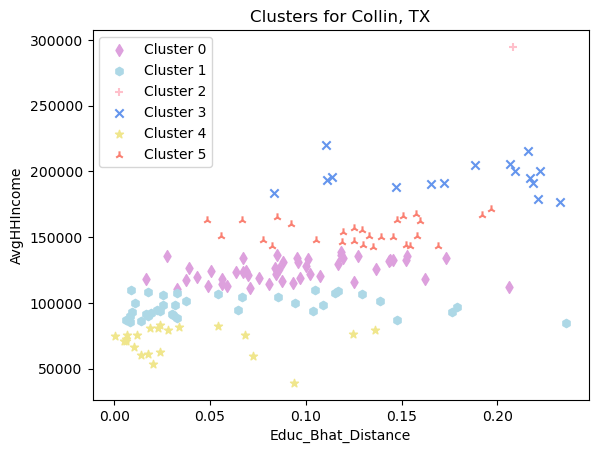

NOT FINISHED.. Wait for re-grouping to original cluster 48113
how many clusters there should be: 6
1    85
3    28
4    22
2    16
5     1
Name: cluster, dtype: int64


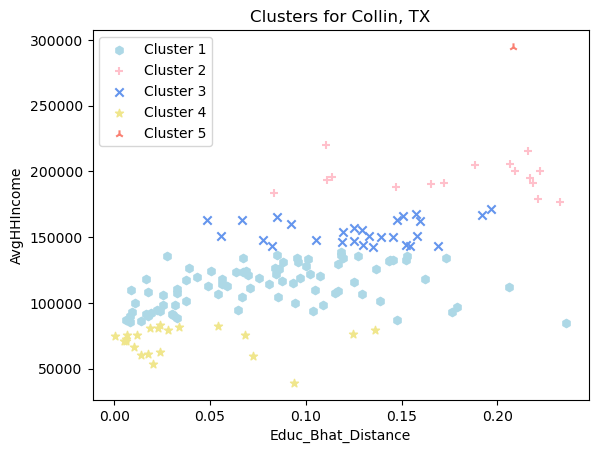

--
Denton, TX
(137, 17)
Amount of available data points for Denton, TX: 137
Amount of available data points after merging with 48113: 137


area.shape
(137, 10)
(137, 10)
X shape
(137, 8)


,TransportWarehouseInd,Manufacturing,AvgHHIncome,AvgDIncome,Age_Bhat_Distance,Gender_Bhat_Distance,Educ_Bhat_Distance,Race_Bhat_Distance
681,225.0,574.0,95823,76201,0.051561,0.002664,0.028245,0.116608
682,353.0,504.0,127609,100010,0.030371,0.002674,0.030068,0.047542
683,440.0,555.0,112431,89763,0.025810,0.003072,0.057786,0.028682
684,410.0,296.0,114482,90604,0.038482,0.002917,0.058942,0.055032
685,284.0,393.0,126163,96315,0.038488,0.003019,0.068360,0.034995
...,...,...,...,...,...,...,...,...
813,107.0,356.0,224716,155562,0.071816,0.002289,0.356636,0.117101
814,225.0,300.0,194739,140194,0.058596,0.003229,0.183542,0.075917
815,308.0,377.0,200434,141995,0.061405,0.002732,0.178149,0.070601
816,0.0,294.0,211594,139639,0.055716,0.003626,0.204450,0.035987


hyperparameter tuning? False
Parameters in use:
algorithm: auto
initializing with: k-means++
clusters: 6


C:\Users\kzhang\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\kzhang\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


[[2.55146341e+02 2.79121951e+02 1.12928000e+05 8.80371220e+04
  4.79738373e-02 2.98599683e-03 5.87176884e-02 6.26485208e-02]
 [1.40000000e+02 3.11333333e+02 2.41363167e+05 1.62943667e+05
  8.31468244e-02 2.40417912e-03 2.19655268e-01 7.40600919e-02]
 [1.21043478e+02 1.84782609e+02 5.55835652e+04 4.67390435e+04
  5.07607290e-02 3.34888608e-03 3.51866356e-02 6.03237153e-02]
 [2.35900000e+02 3.36000000e+02 1.88903750e+05 1.34373450e+05
  5.87986475e-02 2.93641921e-03 1.60246340e-01 6.35330820e-02]
 [1.49892857e+02 2.40285714e+02 8.40107500e+04 6.81442500e+04
  3.05604860e-02 2.98761771e-03 3.19495142e-02 6.37586967e-02]
 [2.11578947e+02 2.72684211e+02 1.46126316e+05 1.10106211e+05
  5.25583692e-02 2.96647867e-03 1.13399788e-01 5.80466593e-02]]
Centroid 0: label 0
Centroid 1: label 1
Centroid 2: label 2
Centroid 3: label 3
Centroid 4: label 4
Centroid 5: label 5


C:\Users\kzhang\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


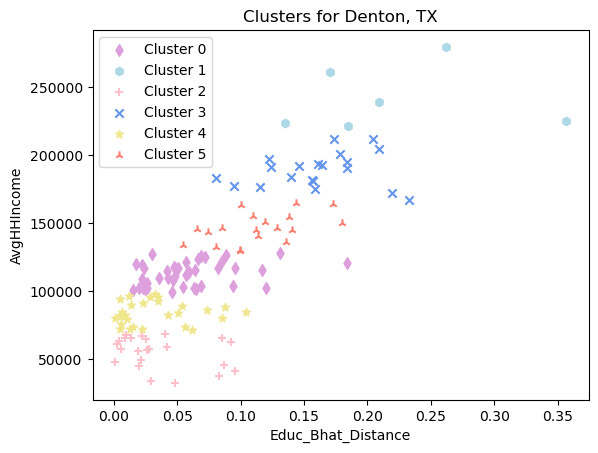

NOT FINISHED.. Wait for re-grouping to original cluster 48113
how many clusters there should be: 6
1    41
4    28
2    26
0    23
3    19
Name: cluster, dtype: int64


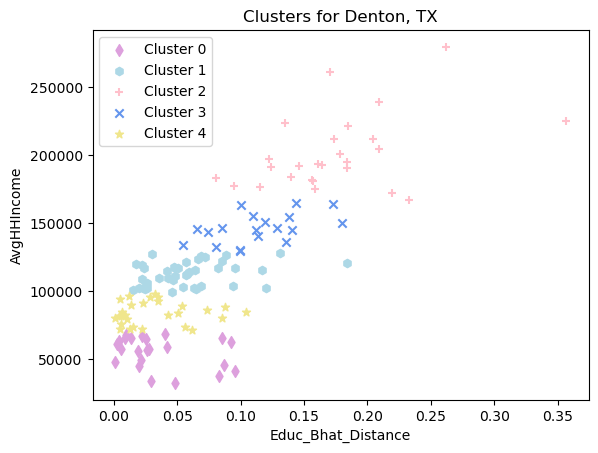

--
Ellis, TX
(31, 17)
Amount of available data points for Ellis, TX: 31
Amount of available data points after merging with 48113: 31


area.shape
(31, 10)
(31, 10)
X shape
(31, 8)


,TransportWarehouseInd,Manufacturing,AvgHHIncome,AvgDIncome,Age_Bhat_Distance,Gender_Bhat_Distance,Educ_Bhat_Distance,Race_Bhat_Distance
818,354.0,290.0,76106,61278,0.058647,0.000663,0.001358,0.059243
819,454.0,539.0,87184,69852,0.061422,0.001444,0.000891,0.084963
820,662.0,602.0,116109,91163,0.062812,0.000786,0.026915,0.026119
821,274.0,185.0,77571,62566,0.046934,0.000155,0.012665,0.049591
822,198.0,278.0,97142,78407,0.068123,0.000635,0.020556,0.034417
823,310.0,257.0,111605,86050,0.069784,0.000600,0.042302,0.030201
824,156.0,249.0,131917,101857,0.068262,0.001192,0.067932,0.010070
825,26.0,48.0,147735,109163,0.096555,0.001487,0.041003,0.082915
826,180.0,252.0,122050,95210,0.090214,0.001841,0.023791,0.049602
827,108.0,426.0,91552,74158,0.050805,0.000959,0.039186,0.038881


hyperparameter tuning? False
Parameters in use:
algorithm: auto
initializing with: k-means++
clusters: 6


C:\Users\kzhang\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\kzhang\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


[[2.43500000e+02 3.36000000e+02 1.25973750e+05 9.72440000e+04
  6.99271151e-02 1.02691299e-03 5.01174067e-02 3.57945186e-02]
 [1.59555556e+02 2.74222222e+02 7.83612222e+04 6.37024444e+04
  6.12985291e-02 7.39766241e-04 8.55139271e-03 5.52010167e-02]
 [3.12666667e+02 3.87166667e+02 1.11618333e+05 8.66233333e+04
  7.35559317e-02 1.12740472e-03 2.37691162e-02 5.23697002e-02]
 [1.13750000e+02 5.27500000e+02 5.71405000e+04 4.71582500e+04
  4.82023646e-02 7.23315828e-04 1.14615624e-02 7.82857403e-02]
 [1.93833333e+02 4.71000000e+02 9.34775000e+04 7.45901667e+04
  7.00967757e-02 9.92087781e-04 1.31254178e-02 6.23585718e-02]
 [8.90000000e+01 3.47500000e+02 1.45333000e+05 1.08705000e+05
  8.59864540e-02 1.29101350e-03 6.80665358e-02 7.17097715e-02]]
Centroid 0: label 0
Centroid 1: label 1
Centroid 2: label 2
Centroid 3: label 3
Centroid 4: label 4
Centroid 5: label 5


C:\Users\kzhang\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


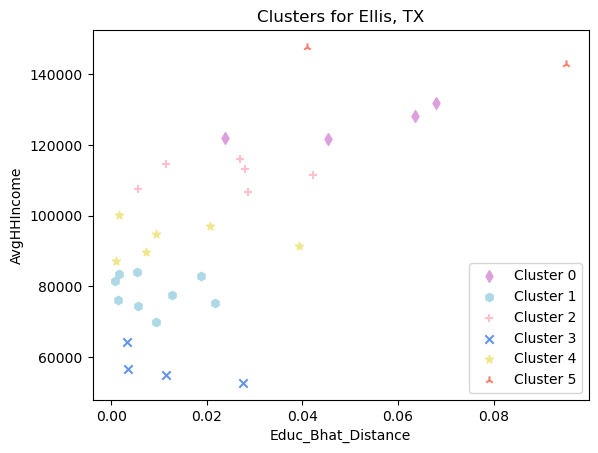

NOT FINISHED.. Wait for re-grouping to original cluster 48113
how many clusters there should be: 6
1    16
4     9
0     4
3     2
Name: cluster, dtype: int64


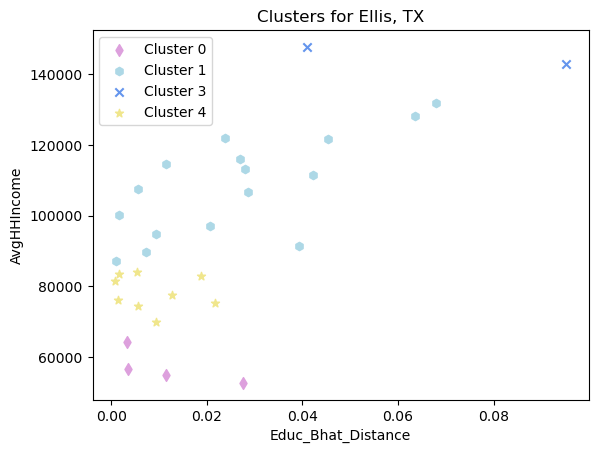

--
Hood, TX
(0, 17)
Amount of available data points for Hood, TX: 0
Using 48113 County warehouse demo data
Amount of available data points after merging with 48113: 152


area.shape
(152, 10)
(152, 10)
X shape
(152, 8)


,TransportWarehouseInd,Manufacturing,AvgHHIncome,AvgDIncome,Age_Bhat_Distance,Gender_Bhat_Distance,Educ_Bhat_Distance,Race_Bhat_Distance
0,206.0,130.0,91700,74004,0.056842,0.004512,0.029904,0.035178
1,92.0,233.0,94726,73506,0.071501,0.005472,0.064641,0.060514
2,70.0,207.0,111216,88513,0.080933,0.004840,0.070832,0.054693
3,66.0,86.0,98203,78932,0.070223,0.003875,0.031576,0.030665
4,135.0,100.0,79089,64603,0.034415,0.003066,0.028139,0.036164
...,...,...,...,...,...,...,...,...
147,77.0,116.0,134267,102636,0.131320,0.004348,0.095463,0.059511
148,45.0,185.0,113099,87738,0.119441,0.003941,0.049186,0.043813
149,58.0,184.0,101488,81190,0.103467,0.004855,0.037588,0.041194
150,19.0,68.0,88296,71366,0.084610,0.003565,0.032514,0.048056


hyperparameter tuning? False
Parameters in use:
algorithm: auto
initializing with: k-means++
clusters: 6


C:\Users\kzhang\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\kzhang\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


[[9.67291667e+01 3.01708333e+02 1.24731458e+05 9.50244792e+04
  7.81650067e-02 4.32729988e-03 9.33625147e-02 4.18217534e-02]
 [1.57054054e+02 3.02783784e+02 9.73051081e+04 7.69828919e+04
  6.27869903e-02 3.90026947e-03 6.35050433e-02 6.41600587e-02]
 [1.60000000e+01 5.90000000e+01 2.94683000e+05 1.85069000e+05
  2.23471197e-01 2.99633443e-03 2.08222578e-01 6.55356780e-02]
 [1.30750000e+02 4.21312500e+02 1.95628688e+05 1.37860062e+05
  1.00864442e-01 3.74488443e-03 1.77264651e-01 9.96354966e-02]
 [1.01772727e+02 2.24318182e+02 7.09458182e+04 5.77780000e+04
  5.84077821e-02 3.45806908e-03 3.62981892e-02 6.29732217e-02]
 [1.13142857e+02 3.25107143e+02 1.54120643e+05 1.13340571e+05
  8.81809558e-02 4.08800046e-03 1.26883275e-01 8.10800470e-02]]
Centroid 0: label 0
Centroid 1: label 1
Centroid 2: label 2
Centroid 3: label 3
Centroid 4: label 4
Centroid 5: label 5


C:\Users\kzhang\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


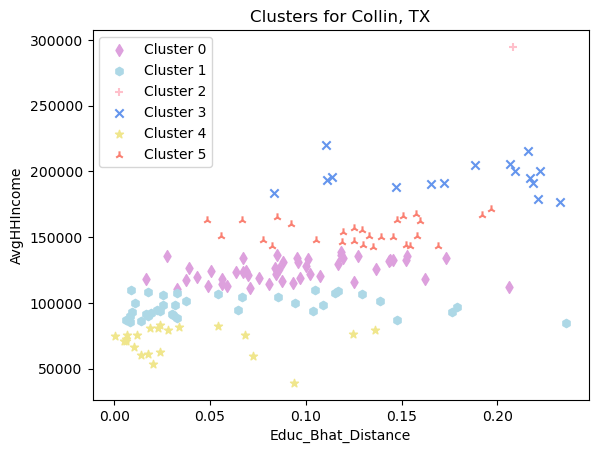

NOT FINISHED.. Wait for re-grouping to original cluster 48113
how many clusters there should be: 6
1    85
3    28
4    22
2    16
5     1
Name: cluster, dtype: int64


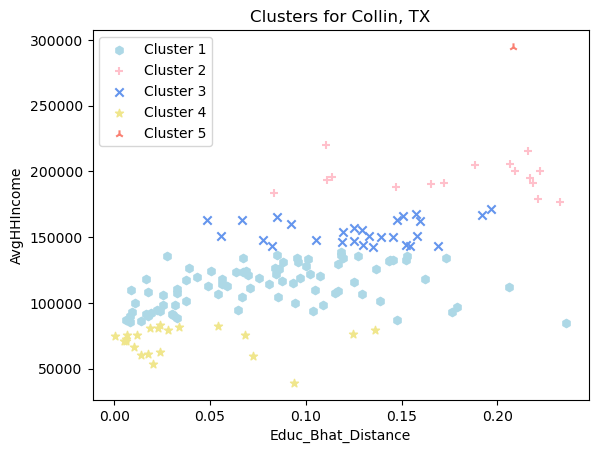

--
Hunt, TX
(19, 17)
Amount of available data points for Hunt, TX: 19
Amount of available data points after merging with 48113: 19


area.shape
(19, 10)
(19, 10)
X shape
(19, 8)


,TransportWarehouseInd,Manufacturing,AvgHHIncome,AvgDIncome,Age_Bhat_Distance,Gender_Bhat_Distance,Educ_Bhat_Distance,Race_Bhat_Distance
859,34.0,181.0,69889,58214,0.225621,0.028986,0.013794,0.184113
860,37.0,122.0,71686,58532,0.202332,0.028920,0.012185,0.133125
861,128.0,404.0,85667,68589,0.210506,0.031834,0.020828,0.081254
862,98.0,460.0,76934,62111,0.203633,0.030010,0.011026,0.190736
863,7.0,191.0,47613,40307,0.224150,0.037768,0.033160,0.238620
864,22.0,120.0,49462,41373,0.430021,0.034482,0.027657,0.307534
865,179.0,365.0,72016,59862,0.216612,0.030919,0.005311,0.084859
866,113.0,309.0,34169,29497,0.251327,0.030455,0.019457,0.477937
867,250.0,448.0,38296,32616,0.198313,0.034781,0.009140,0.372870
868,103.0,262.0,57532,48250,0.220075,0.027141,0.002892,0.264640


hyperparameter tuning? False
Parameters in use:
algorithm: auto
initializing with: k-means++
clusters: 6


C:\Users\kzhang\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\kzhang\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


[[9.48333333e+01 2.77666667e+02 7.20716667e+04 5.87195000e+04
  2.09671413e-01 3.01934913e-02 9.32150354e-03 1.33497464e-01]
 [1.20000000e+01 1.67000000e+02 1.31551000e+05 9.81780000e+04
  2.12056903e-01 2.85356558e-02 2.57726799e-02 8.46812378e-02]
 [1.81500000e+02 3.78500000e+02 3.62325000e+04 3.10565000e+04
  2.24820317e-01 3.26182082e-02 1.42981344e-02 4.25403762e-01]
 [1.87500000e+02 5.51000000e+02 1.01481000e+05 7.91395000e+04
  2.10699811e-01 2.98126666e-02 2.39791871e-02 9.78487186e-02]
 [7.70000000e+01 1.79000000e+02 5.40092000e+04 4.53736000e+04
  2.58208941e-01 3.19562185e-02 1.44947816e-02 1.96850164e-01]
 [1.83000000e+02 4.89000000e+02 8.68813333e+04 7.02563333e+04
  2.04754009e-01 3.23880871e-02 2.27109180e-02 1.02209289e-01]]
Centroid 0: label 0
Centroid 1: label 1
Centroid 2: label 2
Centroid 3: label 3
Centroid 4: label 4
Centroid 5: label 5


C:\Users\kzhang\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


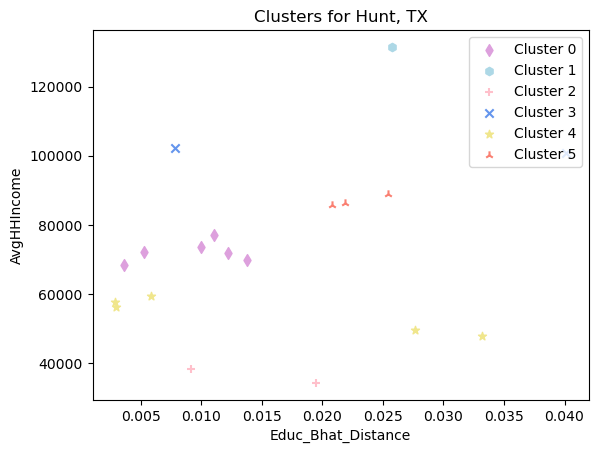

NOT FINISHED.. Wait for re-grouping to original cluster 48113
how many clusters there should be: 6
4    9
0    7
1    2
3    1
Name: cluster, dtype: int64


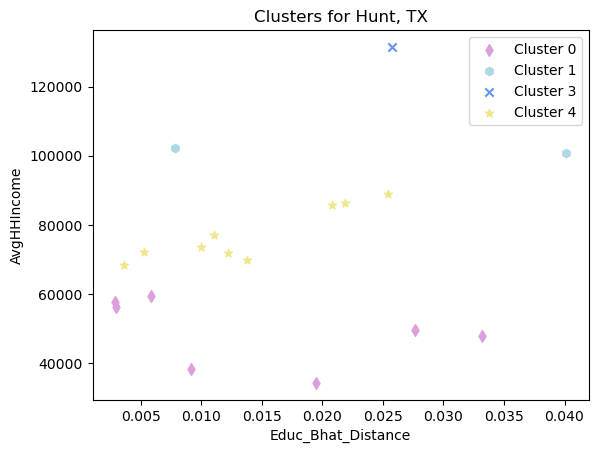

--
Johnson, TX
(28, 17)
Amount of available data points for Johnson, TX: 28
Amount of available data points after merging with 48113: 28


area.shape
(28, 10)
(28, 10)
X shape
(28, 8)


,TransportWarehouseInd,Manufacturing,AvgHHIncome,AvgDIncome,Age_Bhat_Distance,Gender_Bhat_Distance,Educ_Bhat_Distance,Race_Bhat_Distance
878,167.0,136.0,83864,68539,0.037118,2.394683e-04,0.024871,0.094126
879,389.0,787.0,88993,71784,0.020176,1.772031e-05,0.026148,0.051708
880,78.0,260.0,72060,59474,0.031552,1.290207e-05,0.010912,0.085296
881,163.0,517.0,105885,83575,0.037349,6.105815e-06,0.038709,0.077889
882,235.0,236.0,83568,66911,0.029046,6.567878e-06,0.038146,0.067675
883,137.0,324.0,96054,75008,0.030574,1.301073e-04,0.006116,0.073922
884,159.0,257.0,96839,77674,0.045710,1.606385e-06,0.030370,0.086820
885,372.0,303.0,62993,52564,0.021268,6.121826e-05,0.020842,0.089469
886,210.0,180.0,64310,54244,0.024291,3.881293e-04,0.028639,0.086941
887,179.0,365.0,85840,67932,0.025614,1.835784e-05,0.016031,0.082009


hyperparameter tuning? False
Parameters in use:
algorithm: auto
initializing with: k-means++
clusters: 6


C:\Users\kzhang\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\kzhang\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


[[1.20750000e+02 2.37000000e+02 9.57982500e+04 7.62757500e+04
  4.67904559e-02 8.85371175e-05 3.17833269e-02 7.02656619e-02]
 [1.85000000e+02 2.25666667e+02 6.12413333e+04 5.13120000e+04
  2.65099131e-02 1.00397126e-04 1.22730229e-02 7.87572553e-02]
 [1.30500000e+02 2.06000000e+02 4.63550000e+04 3.84985000e+04
  1.50923972e-02 3.19813921e-04 2.63603315e-02 8.07117716e-02]
 [1.84250000e+02 3.94500000e+02 1.05757750e+05 8.37075000e+04
  4.38132904e-02 3.66789188e-05 3.83563819e-02 6.78893357e-02]
 [3.12875000e+02 4.06250000e+02 8.48480000e+04 6.84112500e+04
  2.75669241e-02 3.68886933e-04 1.89032793e-02 7.05606688e-02]
 [2.21250000e+02 3.17750000e+02 7.14387500e+04 5.92415000e+04
  3.35569427e-02 3.81664967e-05 1.25138736e-02 6.62216441e-02]]
Centroid 0: label 0
Centroid 1: label 1
Centroid 2: label 2
Centroid 3: label 3
Centroid 4: label 4
Centroid 5: label 5


C:\Users\kzhang\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


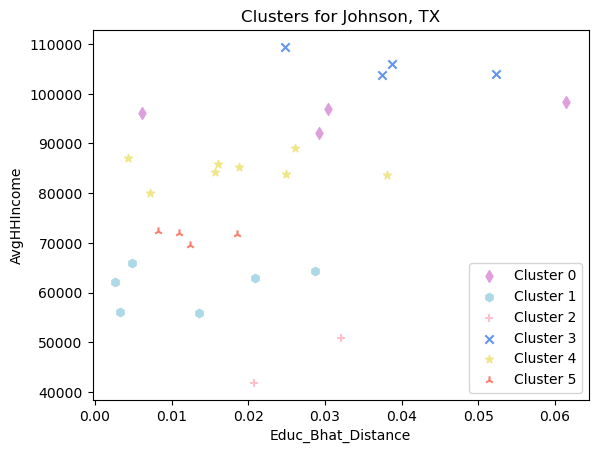

NOT FINISHED.. Wait for re-grouping to original cluster 48113
how many clusters there should be: 6
4    18
1     8
0     2
Name: cluster, dtype: int64


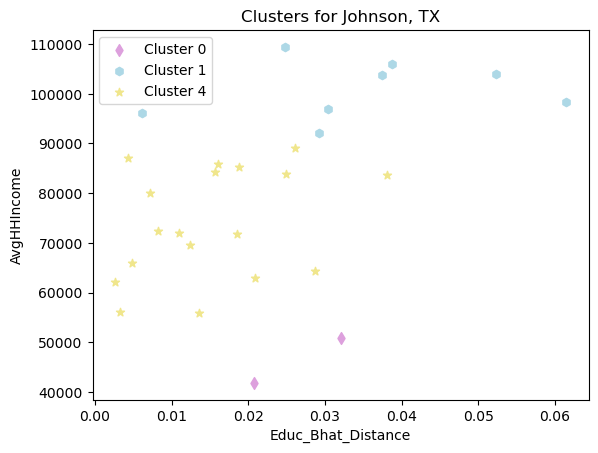

--
Kaufman, TX
(18, 17)
Amount of available data points for Kaufman, TX: 18
Amount of available data points after merging with 48113: 18


area.shape
(18, 10)
(18, 10)
X shape
(18, 8)


,TransportWarehouseInd,Manufacturing,AvgHHIncome,AvgDIncome,Age_Bhat_Distance,Gender_Bhat_Distance,Educ_Bhat_Distance,Race_Bhat_Distance
906,333.0,358.0,101043,81064,0.044289,0.001161,0.025725,0.043763
907,308.0,680.0,101272,80234,0.040281,0.001061,0.011149,0.031746
908,328.0,549.0,97034,77194,0.042554,0.001011,0.010764,0.030435
909,436.0,402.0,118177,93700,0.043819,0.000962,0.031411,0.028767
910,416.0,775.0,122345,95961,0.070960,0.000845,0.035143,0.051022
911,33.0,159.0,66842,54828,0.060097,0.000834,0.003152,0.103131
912,124.0,445.0,73040,60189,0.064414,0.000741,0.005973,0.079939
913,80.0,236.0,48559,39563,0.075561,0.003091,0.017446,0.118030
914,301.0,350.0,77156,64147,0.106139,0.000265,0.018598,0.084966
915,235.0,112.0,104383,80949,0.104167,0.000716,0.005182,0.082615


hyperparameter tuning? False
Parameters in use:
algorithm: auto
initializing with: k-means++
clusters: 6


C:\Users\kzhang\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\kzhang\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


[[2.82000000e+02 4.26000000e+02 9.69110000e+04 7.68473333e+04
  6.63738025e-02 6.90290413e-04 8.99292331e-03 6.31769132e-02]
 [1.53250000e+02 2.01750000e+02 7.81020000e+04 6.40812500e+04
  8.92452055e-02 1.26575069e-04 1.15959772e-02 1.02424144e-01]
 [5.20000000e+01 1.65500000e+02 4.89870000e+04 4.08085000e+04
  6.40083881e-02 1.84793604e-03 2.98584458e-02 1.14017302e-01]
 [4.26000000e+02 5.88500000e+02 1.20261000e+05 9.48305000e+04
  5.73894675e-02 9.03393878e-04 3.32767287e-02 3.98948360e-02]
 [1.30500000e+02 2.80500000e+02 7.12867500e+04 5.80287500e+04
  7.10387789e-02 9.26337521e-04 5.32022742e-03 9.50644446e-02]
 [2.92000000e+02 3.83333333e+02 1.02232667e+05 8.07490000e+04
  6.29121615e-02 9.79077418e-04 1.40182981e-02 5.27079573e-02]]
Centroid 0: label 0
Centroid 1: label 1
Centroid 2: label 2
Centroid 3: label 3
Centroid 4: label 4
Centroid 5: label 5


C:\Users\kzhang\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


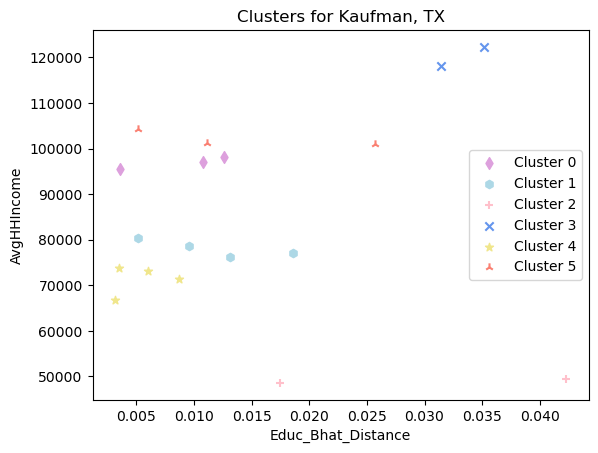

NOT FINISHED.. Wait for re-grouping to original cluster 48113
how many clusters there should be: 6
1    8
4    8
0    2
Name: cluster, dtype: int64


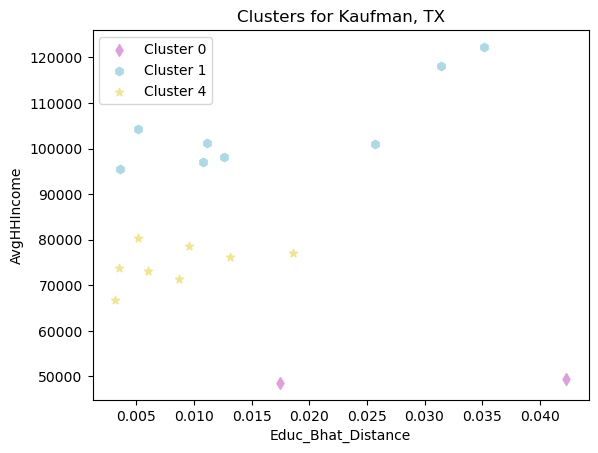

--
Parker, TX
(19, 17)
Amount of available data points for Parker, TX: 19
Amount of available data points after merging with 48113: 19


area.shape
(19, 10)
(19, 10)
X shape
(19, 8)


,TransportWarehouseInd,Manufacturing,AvgHHIncome,AvgDIncome,Age_Bhat_Distance,Gender_Bhat_Distance,Educ_Bhat_Distance,Race_Bhat_Distance
924,172.0,199.0,73454,61056,0.271585,0.025279,0.007159,0.100854
925,79.0,131.0,68126,56266,0.261549,0.016764,0.023280,0.102509
926,91.0,281.0,64849,54467,0.365968,0.027853,0.011597,0.105685
927,126.0,297.0,81501,66710,0.265085,0.019921,0.000686,0.094226
928,327.0,158.0,73447,61219,0.258170,0.019295,0.011046,0.072547
929,237.0,318.0,77444,62538,0.255971,0.018413,0.016879,0.069183
930,629.0,905.0,122828,94130,0.271908,0.017443,0.005802,0.079247
931,339.0,344.0,99615,78706,0.261333,0.018513,0.002946,0.071469
932,186.0,214.0,58222,48594,0.248900,0.016466,0.033877,0.097268
933,282.0,150.0,71047,59405,0.252325,0.021115,0.018934,0.076507


hyperparameter tuning? False
Parameters in use:
algorithm: auto
initializing with: k-means++
clusters: 6


C:\Users\kzhang\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\kzhang\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


[[2.81000000e+02 5.89000000e+02 1.55473000e+05 1.15572000e+05
  2.40321332e-01 2.13969479e-02 6.81950927e-02 5.46699753e-02]
 [3.16000000e+02 3.86000000e+02 9.49152000e+04 7.59320000e+04
  2.61165176e-01 1.82175443e-02 6.33832025e-03 7.12955108e-02]
 [3.59000000e+02 6.82666667e+02 1.29746667e+05 9.88366667e+04
  2.72133207e-01 1.90385202e-02 3.41447616e-02 6.64011972e-02]
 [1.18666667e+02 2.08666667e+02 6.37323333e+04 5.31090000e+04
  2.92138762e-01 2.03610897e-02 2.29181070e-02 1.01820674e-01]
 [3.01500000e+02 5.58000000e+02 1.09224500e+05 8.53275000e+04
  2.58838243e-01 1.86373311e-02 1.09316166e-02 7.76258925e-02]
 [2.28800000e+02 2.24400000e+02 7.53786000e+04 6.21856000e+04
  2.60627195e-01 2.08045645e-02 1.09408234e-02 8.26633193e-02]]
Centroid 0: label 0
Centroid 1: label 1
Centroid 2: label 2
Centroid 3: label 3
Centroid 4: label 4
Centroid 5: label 5


C:\Users\kzhang\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


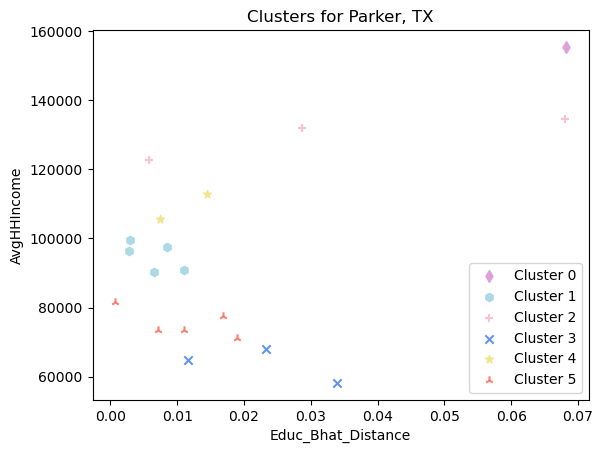

NOT FINISHED.. Wait for re-grouping to original cluster 48113
how many clusters there should be: 6
4    8
1    7
3    4
Name: cluster, dtype: int64


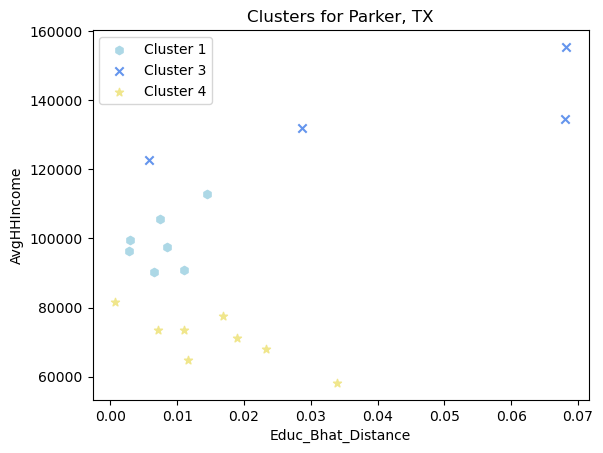

--
Rockwall, TX
(11, 17)
Amount of available data points for Rockwall, TX: 11
Amount of available data points after merging with 48113: 11


area.shape
(11, 10)
(11, 10)
X shape
(11, 8)


,TransportWarehouseInd,Manufacturing,AvgHHIncome,AvgDIncome,Age_Bhat_Distance,Gender_Bhat_Distance,Educ_Bhat_Distance,Race_Bhat_Distance
943,130.0,202.0,153478,112911,0.104601,0.014004,0.187518,0.186093
944,78.0,232.0,136841,102999,0.081815,0.014837,0.115636,0.143170
945,142.0,545.0,155623,115183,0.109259,0.013811,0.152505,0.200637
946,174.0,223.0,115875,90996,0.117093,0.016999,0.056443,0.156288
947,124.0,475.0,97333,76325,0.133892,0.016098,0.079048,0.140030
948,248.0,679.0,113783,89547,0.068275,0.012457,0.046830,0.176345
949,657.0,749.0,115604,89890,0.069551,0.014835,0.067108,0.164712
950,111.0,379.0,89190,71639,0.057516,0.011202,0.014692,0.263960
951,128.0,165.0,164740,118655,0.145396,0.015257,0.119312,0.204785
952,298.0,411.0,133617,102503,0.078134,0.011435,0.067298,0.155836


hyperparameter tuning? False
Parameters in use:
algorithm: auto
initializing with: k-means++
clusters: 6


C:\Users\kzhang\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\kzhang\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


[[3.59666667e+02 5.50333333e+02 1.15087333e+05 9.01443333e+04
  8.49731365e-02 1.47637942e-02 5.67933021e-02 1.65781661e-01]
 [3.67000000e+02 5.92000000e+02 2.00913000e+05 1.40040000e+05
  1.20266929e-01 1.30553978e-02 1.81510619e-01 1.82338593e-01]
 [1.36000000e+02 3.73500000e+02 1.54550500e+05 1.14047000e+05
  1.06929801e-01 1.39072727e-02 1.70011023e-01 1.93365207e-01]
 [1.17500000e+02 4.27000000e+02 9.32615000e+04 7.39820000e+04
  9.57040288e-02 1.36500521e-02 4.68698100e-02 2.01995172e-01]
 [1.88000000e+02 3.21500000e+02 1.35229000e+05 1.02751000e+05
  7.99746004e-02 1.31361110e-02 9.14670938e-02 1.49502930e-01]
 [1.28000000e+02 1.65000000e+02 1.64740000e+05 1.18655000e+05
  1.45395520e-01 1.52572199e-02 1.19311866e-01 2.04784786e-01]]
Centroid 0: label 0
Centroid 1: label 1
Centroid 2: label 2
Centroid 3: label 3
Centroid 4: label 4
Centroid 5: label 5


C:\Users\kzhang\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


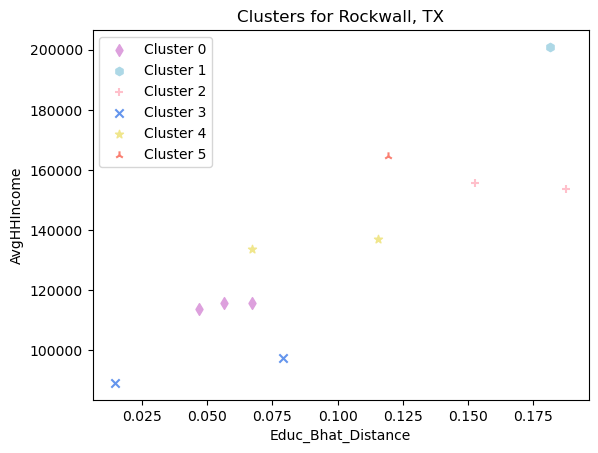

NOT FINISHED.. Wait for re-grouping to original cluster 48113
how many clusters there should be: 6
3    5
1    5
2    1
Name: cluster, dtype: int64


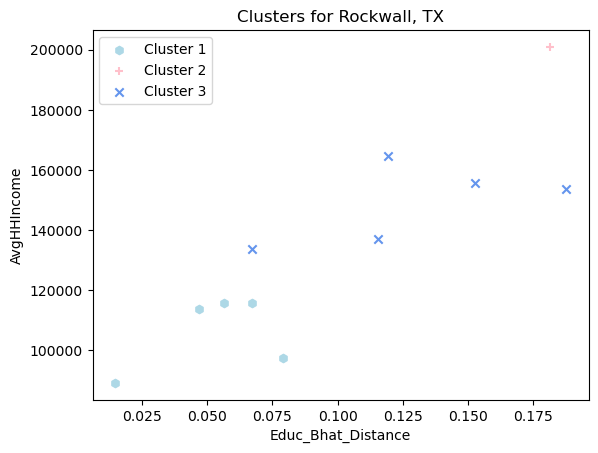

--
Tarrant, TX
(357, 17)
Amount of available data points for Tarrant, TX: 357
Amount of available data points after merging with 48113: 357


area.shape
(357, 10)
(357, 10)
X shape
(357, 8)


,TransportWarehouseInd,Manufacturing,AvgHHIncome,AvgDIncome,Age_Bhat_Distance,Gender_Bhat_Distance,Educ_Bhat_Distance,Race_Bhat_Distance
954,212.0,768.0,63842,53127,0.041891,0.000563,0.031521,0.203691
955,80.0,390.0,83071,65601,0.048006,0.000377,0.004106,0.201383
956,85.0,563.0,46608,40085,0.040854,0.000786,0.088746,0.218463
957,57.0,522.0,58743,48594,0.041944,0.000362,0.119421,0.246336
958,115.0,392.0,53525,43624,0.045875,0.000648,0.059169,0.173919
...,...,...,...,...,...,...,...,...
1306,104.0,260.0,113472,85550,0.036469,0.002598,0.082268,0.017448
1307,77.0,123.0,68964,55318,0.058978,0.000005,0.037192,0.057105
1308,53.0,120.0,46265,38731,0.056408,0.001068,0.024408,0.155017
1309,143.0,237.0,42180,36235,0.039830,0.000032,0.000440,0.078838


hyperparameter tuning? False
Parameters in use:
algorithm: auto
initializing with: k-means++
clusters: 6


C:\Users\kzhang\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\kzhang\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


[[2.62000000e+02 4.07800000e+02 2.38225700e+05 1.61206400e+05
  9.84706514e-02 1.36781959e-03 2.07036523e-01 7.93296513e-02]
 [2.64257143e+02 2.71161905e+02 7.78926952e+04 6.34415810e+04
  5.35146892e-02 2.10661049e-03 2.65997116e-02 7.28687825e-02]
 [1.44200000e+02 2.94800000e+02 1.77448800e+05 1.26742600e+05
  1.04222964e-01 1.93074416e-03 1.79006773e-01 7.12147177e-02]
 [1.51910714e+02 2.49830357e+02 5.11557143e+04 4.29291071e+04
  5.04780792e-02 1.33803463e-03 3.22309776e-02 1.49700905e-01]
 [3.22277778e+02 3.98805556e+02 1.35561417e+05 1.01760056e+05
  7.36441861e-02 1.67529860e-03 9.97454740e-02 6.12010079e-02]
 [3.61949367e+02 3.54531646e+02 1.03624759e+05 8.13272152e+04
  6.17242884e-02 1.73300728e-03 5.67325486e-02 5.44756916e-02]]


C:\Users\kzhang\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


Centroid 0: label 0
Centroid 1: label 1
Centroid 2: label 2
Centroid 3: label 3
Centroid 4: label 4
Centroid 5: label 5


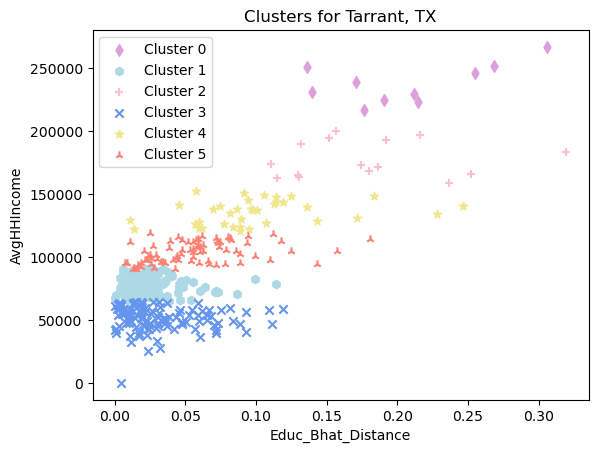

NOT FINISHED.. Wait for re-grouping to original cluster 48113
how many clusters there should be: 6
0    112
4    105
1     79
3     51
2     10
Name: cluster, dtype: int64


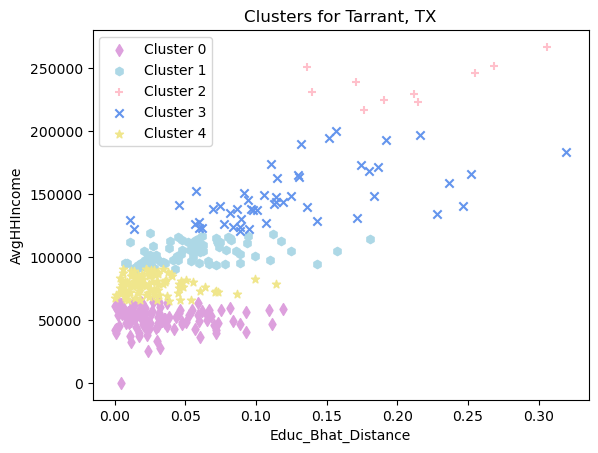

In [48]:
'''KZ'''
def main2(workers, tracts):
    mapping_df = pd.read_excel(r'C:\Projects\Constellation Warehouse Employee Demographic Clustering\Texas - Labor Analysis - 2 MSA Sample.xlsx')
    
    all_results = []
    
    for index, row in mapping_df.iterrows():
        centroid_county_name = row['County 1']
        project_place = row['MSA Name']
        DATA_ROW_LIMIT = 10
#         list_of_tracts = row[2:].values.astype(float).tolist()
        list_of_tracts = [val for val in row[2:].values.astype(float).tolist() if not np.isnan(val)]
        focus_tracts_by_id = True
        using_geo_data = False
        
#         focus_tracts = get_focus_tracts(focus_tracts_by_id, workers, list_of_tracts)
        focus_tracts = list_of_tracts
    
        county_dic = county_xrf(focus_tracts)
        print(f'county_dic: {county_dic}')
        # initializing order in which they will be clustered, order matters
        county_order = {k: i for i, k in enumerate(focus_tracts)}
        county_order = prioritize_county(county_order, centroid_county_name)
        order = sorted(county_order.keys(), key=lambda x: county_order[x])
        order = [val for val in order if not np.isnan(val)]
        
        workers = workers.sort_values(by='CountyFIPS', key=lambda x: pd.Categorical(x, categories=order))
        tracts = tracts.drop_duplicates(subset='ID')
        tracts = tracts.sort_values(by='CountyFIPS', key=lambda x: pd.Categorical(x, categories=order))
        
        # Call main and capture the returned all_area DataFrame
        result = main(centroid_county_name, DATA_ROW_LIMIT, project_place, focus_tracts, using_geo_data, order, county_dic)
        all_results.append(result)  # Add the result to the list

        
    # Concatenate all the all_area DataFrames
    final_all_area = pd.concat(all_results, ignore_index=True)

    return final_all_area  # Return the concatenated all_area DataFrame
        
final_all_area = main2(workers, tracts)


In [49]:
final_all_area

,ID,TransportWarehouseInd,Manufacturing,AvgHHIncome,AvgDIncome,CountyFIPS,Age_Bhat_Distance,Gender_Bhat_Distance,Educ_Bhat_Distance,Race_Bhat_Distance,cluster,tier
0,48201100000,251.0,441.0,137949,97553,48201.0,0.023382,0.002428,0.124685,0.040191,3,4
1,48201210100,2.0,4.0,152334,110150,48201.0,0.038610,0.068161,0.042980,0.050605,3,4
2,48201210400,94.0,191.0,41961,35619,48201.0,0.049634,0.001146,0.021169,0.133505,0,1
3,48201210500,128.0,233.0,47845,39809,48201.0,0.051108,0.001588,0.014368,0.170294,0,1
4,48201210600,302.0,219.0,73778,60652,48201.0,0.068143,0.001411,0.020895,0.179721,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...
3551,48439123300,104.0,260.0,113472,85550,48439.0,0.036469,0.002598,0.082268,0.017448,1,3
3552,48439123400,77.0,123.0,68964,55318,48439.0,0.058978,0.000005,0.037192,0.057105,4,2
3553,48439123500,53.0,120.0,46265,38731,48439.0,0.056408,0.001068,0.024408,0.155017,0,1
3554,48439123600,143.0,237.0,42180,36235,48439.0,0.039830,0.000032,0.000440,0.078838,0,1


In [50]:
# handle duplicate items (harris county census tracts were reused for smaller counties' clustering)
# calculate the mode of the 'cluster' column for each group in 'col1'
mode = final_all_area.groupby('ID')['cluster'].transform(lambda x: x.mode()[0])

# add the 'mode' column to the DataFrame
final_all_area['cluster'] = mode

# drop the duplicated rows based on 'ID'
final_all_area.drop_duplicates(subset=['ID'], inplace = True)

In [52]:
# plot_kmeans(final_all_area)

NameError: name 'county_dic' is not defined

# Interpret Results

In [53]:
# Rank cluster names in accordance to plot above
# We are usually interested in the lower part of the spectrum
final_all_area['AvgHHIncome']

0       137949
1       152334
2        41961
3        47845
4        73778
         ...  
3551    113472
3552     68964
3553     46265
3554     42180
3555         0
Name: AvgHHIncome, Length: 2354, dtype: int64

In [54]:
mean_clus_incomes = final_all_area.groupby(['cluster'], as_index = False).agg({'AvgHHIncome': 'mean'})

In [55]:
mean_clus_incomes

,cluster,AvgHHIncome
0,0,47975.994836
1,1,104684.439024
2,2,204621.257426
3,3,149499.977987
4,4,72552.011396
5,5,279955.405405


In [56]:
# Sort in ascending order 
tiers_df = mean_clus_incomes.sort_values(by='AvgHHIncome')
tiers_df

,cluster,AvgHHIncome
0,0,47975.994836
4,4,72552.011396
1,1,104684.439024
3,3,149499.977987
2,2,204621.257426
5,5,279955.405405


In [57]:
tiers = tiers_df['cluster'].to_list()

In [58]:
# Open a new file in write mode & save 'tiers' of labor pool
with open('tiers.txt', 'w') as file:
    for rank, i in enumerate(tiers):
        print(f'tier: {rank+1}')
        print(f'cluster no. {i}')
        print(f'color: {colours[i]}')
    
        output_text = f'tier: {rank+1}\n' \
                      f'cluster no. {i}\n' \
                      f'color: {colours[i]}\n\n'
        file.write(output_text)

tier: 1
cluster no. 0
color: plum
tier: 2
cluster no. 4
color: khaki
tier: 3
cluster no. 1
color: lightblue
tier: 4
cluster no. 3
color: cornflowerblue
tier: 5
cluster no. 2
color: pink
tier: 6
cluster no. 5
color: salmon


In [ ]:
interest_tiers = tiers[:3]

# Save Results

In [ ]:
#all_area.to_excel('Warehouse Demo Clusters GA (no missing tracts).xlsx', header = True, index = False)

In [ ]:
final_all_area.to_excel(f'Warehouse Clusters.xlsx', header = True, index = False)

In [ ]:
focused_area = final_all_area.loc[final_all_area.cluster.isin(interest_tiers)]

In [ ]:
focused_area.to_excel(f'Warehouse Demo Clusters {project_place} focused.xlsx', header = True, index = False)

In [ ]:
if using_geo_data:
    m = map_tracts(all_area)
    m.save(f'{project_place} Clusters.html')

# Plot


In [ ]:
stop

In [ ]:
    # note there are already functions for these - edit here if you'd like
    county_num = all_area['CountyFIPS'].tolist()[0]
    county_name = county_dic[county_num]
    fig, ax = plt.subplots()
    colors = ['plum', 'lightblue', 'pink', 'cornflowerblue','khaki', 'salmon', 'violet', 'palegreen']
    markers = [ 'd','h', '+', 'x','*', '2', '3', '4']
    for i, cluster in all_area.groupby('cluster'):
        x = 'Manufacturing'
        y = 'TransportWarehouseInd'
        ax.scatter(cluster[x], cluster[y], c=colors[i], marker=markers[i], label=f'Cluster {i}')
    ax.legend()
    ax.set_xlabel(f'{x}')
    ax.set_ylabel(f'{y}')
    ax.set_title(f'Clusters for {county_name}')
    #plt.savefig(f'{county_name}_income_educ_plot.png')
    plt.show()

In [ ]:
    county_num = all_area['CountyFIPS'].tolist()[0]
    county_name = county_dic[county_num]
    fig, ax = plt.subplots()
    colors = ['plum', 'lightblue', 'pink', 'cornflowerblue','khaki', 'salmon', 'violet', 'palegreen']
    markers = [ 'd','h', '+', 'x','*', '2', '3', '4']
    for i, cluster in all_area.groupby('cluster'):
        x = 'Manufacturing'
        y = 'AvgHHIncome'
        ax.scatter(cluster[x], cluster[y], c=colors[i], marker=markers[i], label=f'Cluster {i}')
    ax.legend()
    ax.set_xlabel(f'{x}')
    ax.set_ylabel(f'{y}')
    ax.set_title(f'Clusters for {county_name}')
    #plt.savefig(f'{county_name}_income_educ_plot.png')
    plt.show()

In [ ]:
    county_num = all_area['CountyFIPS'].tolist()[0]
    county_name = county_dic[county_num]
    fig, ax = plt.subplots()
    colors = ['plum', 'lightblue', 'pink', 'cornflowerblue','khaki', 'salmon', 'violet', 'palegreen']
    markers = [ 'd','h', '+', 'x','*', '2', '3', '4']
    for i, cluster in all_area.groupby('cluster'):
        x = 'Age_Bhat_Distance'
        y = 'Educ_Bhat_Distance'
        ax.scatter(cluster[x], cluster[y], c=colors[i], marker=markers[i], label=f'Cluster {i}')
    ax.legend()
    ax.set_xlabel(f'{x}')
    ax.set_ylabel(f'{y}')
    ax.set_title(f'Clusters for {county_name}')
    #plt.savefig(f'{county_name}_income_educ_plot.png')
    plt.show()

In [ ]:
    county_num = all_area['CountyFIPS'].tolist()[0]
    county_name = county_dic[county_num]
    fig, ax = plt.subplots()
    colors = ['plum', 'lightblue', 'pink', 'cornflowerblue','khaki', 'salmon', 'violet', 'palegreen']
    markers = [ 'd','h', '+', 'x','*', '2', '3', '4']
    for i, cluster in all_area.groupby('cluster'):
        x = 'Age_Bhat_Distance'
        y = 'AvgHHIncome'
        ax.scatter(cluster[x], cluster[y], c=colors[i], marker=markers[i], label=f'Cluster {i}')
    ax.legend()
    ax.set_xlabel(f'{x}')
    ax.set_ylabel(f'{y}')
    ax.set_title(f'Clusters for {county_name}')
    #plt.savefig(f'{county_name}_income_educ_plot.png')
    plt.show()

In [ ]:
    county_num = all_area['CountyFIPS'].tolist()[0]
    county_name = county_dic[county_num]
    fig, ax = plt.subplots()
    colors = ['plum', 'lightblue', 'pink', 'cornflowerblue','khaki', 'salmon', 'violet', 'palegreen']
    markers = [ 'd','h', '+', 'x','*', '2', '3', '4']
    for i, cluster in all_area.groupby('cluster'):
        x = 'Race_Bhat_Distance'
        y = 'Age_Bhat_Distance'
        ax.scatter(cluster[x], cluster[y], c=colors[i], marker=markers[i], label=f'Cluster {i}')
    ax.legend()
    ax.set_xlabel(f'{x}')
    ax.set_ylabel(f'{y}')
    ax.set_title(f'Clusters for {county_name}')
    #plt.savefig(f'{county_name}_income_educ_plot.png')
    plt.show()

In [ ]:
    county_num = all_area['CountyFIPS'].tolist()[0]
    county_name = county_dic[county_num]
    fig, ax = plt.subplots()
    colors = ['plum', 'lightblue', 'pink', 'cornflowerblue','khaki', 'salmon', 'violet', 'palegreen']
    markers = [ 'd','h', '+', 'x','*', '2', '3', '4']
    for i, cluster in all_area.groupby('cluster'):
        x = 'Race_Bhat_Distance'
        y = 'AvgHHIncome'
        ax.scatter(cluster[x], cluster[y], c=colors[i], marker=markers[i], label=f'Cluster {i}')
    ax.legend()
    ax.set_xlabel(f'{x}')
    ax.set_ylabel(f'{y}')
    ax.set_title(f'Clusters for {county_name}')
    #plt.savefig(f'{county_name}_income_educ_plot.png')
    plt.show()

# Ignore

In [ ]:
stop

In [ ]:
# there are no duplicate items
# os.chdir(cur_dir)

dups = final_all_area[final_all_area.ID.duplicated()].sort_values(by = 'ID')
dups
#dups.to_excel('dups.xlsx')